In [2]:
%matplotlib inline

from matplotlib_inline import backend_inline
import numpy as np
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import sqrt
from datetime import datetime
from torch.utils import data
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from IPython.display import display
from sklearn.metrics import r2_score

backend_inline.set_matplotlib_formats('svg')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
plt.rcParams['font.sans-serif'] = ['SimHei']

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps')
# device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')


## 加载数据

In [3]:
# convert str to datatime
# 将字符串转换为时间
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# load .mat data
# 加载.mat格式的数据
def loadMat(matfile):
    data_mat = scipy.io.loadmat(matfile)
    filename = matfile.split("/")[-1].split(".")[0]
    col = data_mat[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data_mat = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data_mat.append(d1)

    return data_mat

# get capacity data
# 得到电池容量的数据
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]

Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = './datasets/NASA/'

Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data_mat = loadMat(path)
    Battery[name] = getBatteryCapacity(data_mat)

Load Dataset B0005.mat ...


C:\Users\Coyle\AppData\Local\Temp\ipykernel_12872\3199085973.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2


Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


In [4]:
len(Battery['B0006'][0]), len(Battery['B0006'][1])

(168, 168)

## 画出数据

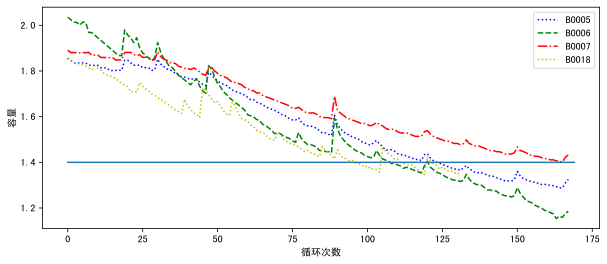

In [5]:
%matplotlib inline

def matplot_battery_list(battery_data_list):
    color_list = ['b:', 'g--', 'r-.', 'y:']
    # 1.创建画布
    plt.figure(figsize=(10, 4), dpi=80)
    plt.xlabel('循环次数')
    plt.ylabel('容量')

    # 2.绘制折线图
    for index, data in enumerate(battery_data_list):
        plt.plot([i for i in range(len(battery_data_list[index]))], battery_data_list[index], color_list[index])

    plt.plot([i for i in range(170)], [1.4] * 170)

    # 图例
    plt.legend([name for name in Battery_list])

Battery_data_list = [Battery['B0005'][1], Battery['B0006'][1], Battery['B0007'][1], Battery['B0018'][1]]
matplot_battery_list(Battery_data_list)

## 创建评估指标函数

In [6]:
# 平均绝对误差、均方根误差
def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    r2 = r2_score(y_test, y_predict)
    return mae, rmse, r2

# 相对误差
# B0005 第125次循环后达到阈值1.4
# B0006 第109次循环后达到阈值1.4
# B0007 数据集中无任何值小于1.4，所以无法达到阈值1.4
# B0018 第97次循环后达到阈值1.4
def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), len(y_predict)
    for i in range(len(y_test) - 1):
        if y_test[i] <= threshold >= y_test[i + 1]:
            true_re = i + 1
            break
    for i in range(len(y_predict) - 1):
        if y_predict[i] <= threshold >= y_predict[i + 1]:
            pred_re = i + 1
            break
    return abs(true_re - pred_re) / true_re

# relative_error(Battery['B0006'][1], Battery['B0006'][1], 1.4)

## 卡尔曼滤波

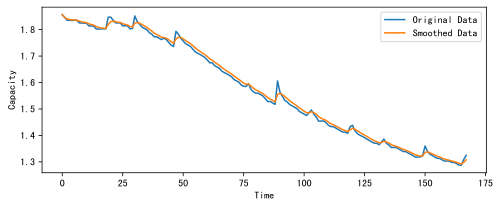

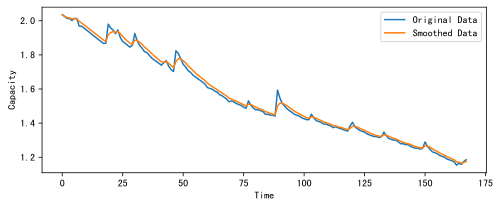

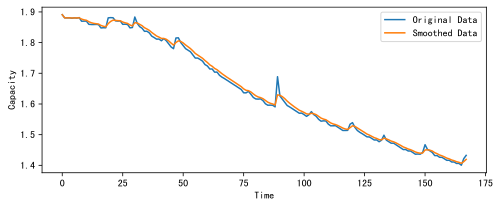

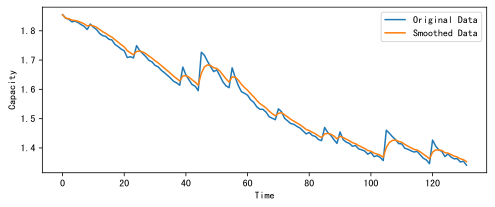

battery_index:0    , MAE:0.0090 , RMSE:0.0107 , RE:0.0160
battery_index:1    , MAE:0.0150 , RMSE:0.0185 , RE:0.0183
battery_index:2    , MAE:0.0076 , RMSE:0.0094 , RE:0.0000
battery_index:3    , MAE:0.0132 , RMSE:0.0163 , RE:0.0206


In [36]:
# Kalman滤波函数
def kalman_filter(data, process_variance, measurement_variance):
    # 初始化滤波器参数
    state = data[0]  # 初始状态
    state_estimate = state
    estimate_error = 1.0
    
    # 存储平滑后的数据
    smoothed_data = [state]
    
    for measurement in data[1:]:
        # 预测步骤
        prediction = state_estimate
        prediction_error = estimate_error + process_variance
        
        # 更新步骤
        kalman_gain = prediction_error / (prediction_error + measurement_variance)
        state_estimate = prediction + kalman_gain * (measurement - prediction)
        estimate_error = (1 - kalman_gain) * prediction_error
        
        # 存储平滑后的数据
        smoothed_data.append(state_estimate)
        state = state_estimate
    
    return np.array(smoothed_data)

Kalman_battery_data_list = []
for b_data in Battery_data_list:
    # 原始的时间序列数据
    original_data = b_data
    # 使用Kalman滤波
    process_variance = 0.001  # 系统噪音方差
    measurement_variance = 0.005  # 观测噪音方差
    smoothed_data = kalman_filter(original_data, process_variance, measurement_variance)
    Kalman_battery_data_list.append(smoothed_data)

    # 可视化原始数据和平滑后的数据
    fig = plt.figure(figsize=(8, 3), dpi=80)
    plt.plot(original_data, label='Original Data')
    plt.plot(smoothed_data, label='Smoothed Data')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Capacity')
    display(fig)
    plt.close()

# 检查下 卡尔曼滤波后的数据的指标评分
rate_i = 0
for o_data, k_data in zip(Battery_data_list, Kalman_battery_data_list):
    mae, rmse, r2 = evaluation(o_data, k_data)
    re = relative_error(o_data, k_data, threshold=2 * 0.7)
    battery_index = rate_i
    rate_i+=1
    print('battery_index:{:<4d} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f}'.format(battery_index, mae, rmse, re))

## 构建训练序列数据

In [11]:
# 构建数据
# 采用 留一评估：一组数据为测试集，其他所有数据全部拿来训练
# train_x 的维度是 window_size ，总样本数为 421
# train_y 的维度是1，总样本数为421
# train_data 是模型预测时的真实数据，用来预测下一时刻的容量，长度为 window_size
# test_data 是 真实的容量数据，用来检验模型的各种参数

def build_seq(text, window_size):
    # text:list of capacity
    x, y = [], []
    for i in range(len(text) - window_size):
        sequence = text[i:i + window_size]
        target = text[i + 1:i + window_size + 1]
        x.append(sequence)
        y.append(target)

    return np.array(x), np.array(y)

def get_train_test_data(data_list, battery_i, window_size=16):
    data_sequence = Battery[Battery_list[battery_i]][1]
    train_data, test_data = data_sequence[:window_size], data_sequence[window_size:]
    
    train_x, train_y = None, None
    for i, v in enumerate(data_list):
        if i != battery_i:
            data_x, data_y = build_seq(text=v, window_size=window_size)
            if train_x is None:
                train_x = data_x
                train_y = data_y
            else:
                train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]

    return train_x, train_y, list(train_data), list(test_data)

def load_capacity_data(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

## 检验 train_iter 数据是否正确

In [12]:
train_x, train_y, train_data, test_data = get_train_test_data(Kalman_battery_data_list, 0, window_size=16)
train_x = torch.from_numpy(train_x.astype(np.float32))
train_y = torch.from_numpy(train_y.astype(np.float32))
train_iter = load_capacity_data((train_x, train_y), 2, is_train=False)

# 测试 train_iter 的数据是否正确
def validate_train_iter(train_iter):
    for x, y in train_iter:
        print(x.shape)
        print(y.shape)
        
        print(x)
        print(y)
        break



validate_train_iter(train_iter)

torch.Size([2, 16])
torch.Size([2, 16])
tensor([[2.0353, 2.0254, 2.0186, 2.0161, 2.0091, 2.0112, 2.0120, 1.9932, 1.9823,
         1.9714, 1.9602, 1.9492, 1.9379, 1.9266, 1.9155, 1.9041],
        [2.0254, 2.0186, 2.0161, 2.0091, 2.0112, 2.0120, 1.9932, 1.9823, 1.9714,
         1.9602, 1.9492, 1.9379, 1.9266, 1.9155, 1.9041, 1.8929]])
tensor([[2.0254, 2.0186, 2.0161, 2.0091, 2.0112, 2.0120, 1.9932, 1.9823, 1.9714,
         1.9602, 1.9492, 1.9379, 1.9266, 1.9155, 1.9041, 1.8929],
        [2.0186, 2.0161, 2.0091, 2.0112, 2.0120, 1.9932, 1.9823, 1.9714, 1.9602,
         1.9492, 1.9379, 1.9266, 1.9155, 1.9041, 1.8929, 1.8819]])


## 绘制 out 和  tgt_y的对比图

In [13]:
# 绘制 out  tgt_y的对比图
def matlab_make(out, tgt_y):
    color_list = ['b:', 'g:']
    # 1.创建画布
    fig = plt.figure(figsize=(7, 2), dpi=80)
    plt.xlabel('循环次数')
    plt.ylabel('容量')
    
    data_list = [
        {
            'name': 'out',
            'x': [i for i in range(len(out))],
            'y': out
        },
        {
            'name': 'tgt_y',
            'x': [i for i in range(len(tgt_y))],
            'y': tgt_y
        }
    ]

    # 2.绘制折线图
    for data,color in zip(data_list, color_list):
        plt.plot(data['x'], data['y'], color)


    # 图例
    plt.legend([data['name'] for data in data_list])
    
    display(fig)
    plt.close() 

# out_t = [1,2,3,4,5,6,7,8,9,10]
# tgt_y_t = [11,21,31,41,51,61,71,81,91,110]

# matlab_make(out_t, tgt_y_t)

## 2维数据的残差1D卷积网络

In [14]:
# 残差网络
class Residual1D(nn.Module):
    def __init__(self, input_channels, num_channels, kernel_size, strides=1):
        super().__init__()
        
        self.conv1 = nn.Conv1d(input_channels, num_channels, kernel_size=3, stride=strides, padding=1)
        self.conv2 = nn.Conv1d(num_channels, num_channels, kernel_size=3, stride=strides, padding=1)
        
        self.bn1 = nn.BatchNorm1d(num_channels)
        self.bn2 = nn.BatchNorm1d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        
        X = torch.cat([X, X], dim=1)
        
        Y = X + Y
        return F.relu(Y)


    
blk = Residual1D(32, 64, 3)
X = torch.rand(50, 32, 16)
Y = blk(X)
Y.shape

torch.Size([50, 64, 16])

## 随机种子

In [15]:
# 设置随机种子
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)  # 为了禁止hash随机化，使得实验可复现。
    torch.manual_seed(seed)  # 为CPU设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

## 搭建模型

In [16]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # 初始化Shape为(max_len, d_model)的PE (positional encoding)
        pe = torch.zeros(max_len, d_model)
        # 初始化一个tensor [[0, 1, 2, 3, ...]]
        position = torch.arange(0, max_len).unsqueeze(1)
        # 这里就是sin和cos括号中的内容，通过e和ln进行了变换
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        # 计算PE(pos, 2i)
        pe[:, 0::2] = torch.sin(position * div_term)
        # 计算PE(pos, 2i+1)
        pe[:, 1::2] = torch.cos(position * div_term)
        # 为了方便计算，在最外面在unsqueeze出一个batch
        pe = pe.unsqueeze(0)
        # 如果一个参数不参与梯度下降，但又希望保存model的时候将其保存下来
        # 这个时候就可以用register_buffer
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x 为embedding后的inputs，例如(1,7, 128)，batch size为1,7个单词，单词维度为128
        """
        # 将x和positional encoding相加。
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)


class Net(nn.Module):

    def __init__(self, d_model=128, nhead=16, num_encoder_layers=2, dim_feedforward=512, kernel_size=3, dropout=0.1):
        super(Net, self).__init__()

        # 定义TransformerEncoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, 
                                                    nhead=nhead, 
                                                    dim_feedforward=dim_feedforward, 
                                                    dropout=dropout, 
                                                    batch_first=True)
        self.transformerEncoder = nn.TransformerEncoder(encoder_layers, num_layers=num_encoder_layers)
        
        self.linear_embedding = nn.Linear(1, d_model)

        # 定义位置编码器
        self.positional_encoding = PositionalEncoding(d_model, dropout=0)
        
        # 残差卷积网络层
        self.rcnn = Residual1D(d_model, d_model * 2, kernel_size=kernel_size)

        # 定义最后的线性层，这里并没有用Softmax，因为没必要。
        # 因为后面的CrossEntropyLoss中自带了
        self.predictor = nn.Linear(d_model * 2, 1)

    def forward(self, x):
        

        # 对 x 进行编码
        x = x.reshape(x.shape[0], x.shape[1], 1)
        
        x = self.linear_embedding(x)
        
        # 给x的token增加位置信息
        x = self.positional_encoding(x)
    
        
        out = self.transformerEncoder(x)
        #print(out.shape)
        
        
        # 残差卷积网络层
        out = out.permute(0, 2, 1)
        out = self.rcnn(out).permute(0, 2, 1) # 输出 out shape: (batch_size, seq_len, d_model * 2)

        out = self.predictor(out)
    
        return out

## 测试模型的输出形状

In [17]:
# 测试模型的输出形状
net = Net(d_model=32).to(device)

# src = torch.LongTensor([[0, 3, 4, 5, 6, 1, 2, 2]])
x = torch.ones((50, 16), dtype=torch.float32).to(device)

out = net(x)
print(out.size())

torch.Size([50, 16, 1])


## 一个批次的训练函数

In [18]:
def train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity): 
    # 将模型设置为训练模式
    net.train()
    
    # 训练损失总和、训练准确度总和、样本数
    for x, y in train_iter:
        # 计算梯度并更新参数
        x = torch.reshape(x / Rated_Capacity, (-1, x.shape[-1])).type(torch.float32)
        y = torch.reshape(y / Rated_Capacity, (-1, y.shape[-1])).type(torch.float32)
        
        x, y = x.to(device), y.to(device)
        #print(src.device)
        #print(tgt.device)
        
        out = net(x)
        
    
        #print('111out', out.shape) # (50, 153, 1)
        # print('111tgt_y', tgt_y.shape) # (50, 153)
        
        l = loss(out.reshape(-1), y.reshape(-1))
        
        #print('222out', out[-1, :, :].cpu().data.numpy().shape) # (50, 153, 1)
        #print('222tgt_y', tgt_y.shape) # (50, 153)
        
        updater.zero_grad()
        l.backward()
        updater.step()
    
    return l

## 总的训练函数

In [38]:
def train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed):
    net = net.to(device)
    
    mae_epoch_list, rmse_epoch_list, re_epoch_list, r2_epoch_list = [], [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        
        # if (epoch + 1) % 100 == 0:
        pre_list = predict(net, train_data, test_data, Rated_Capacity)
        test_y = test_data.copy()

        mae, rmse, r2 = evaluation(test_data, pre_list)
        re = relative_error(test_y, pre_list, threshold=Rated_Capacity * 0.7)

        if (len(re_epoch_list) == 0 or (r2_epoch_list[-1] < r2)):
            print('seed: {}, 测试集: {}, epoch:{:<4d} , loss:{:<6.10f} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f} , R2:{:<6.4f}'.format(seed, Battery_list[i], epoch + 1, train_loss, mae, rmse, re, r2))
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
            r2_epoch_list.append(r2)


        # matlab_make(pre_list, test_y)

        # if (train_loss < 1e-3) and len(re_epoch_list) > 0 and 0.0 < re_epoch_list[-1] < 0.2 and (re_epoch_list[-1] < re):
        #     break

    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1], r2_epoch_list[-1]

## 预测函数

In [32]:
def predict(net, train_data, test_data, Rated_Capacity):
    net = net.eval()
    
    x = train_data.copy()
    x = np.array(x)
    x = torch.from_numpy(x).type(torch.float32).to(device)
    x = torch.reshape(x / Rated_Capacity, (1, -1)) # shape: (batch_size, input_size)
    
    pre_list = []
    while len(pre_list) < len(test_data):
        
        
        out = net(x)
        x = torch.cat([x[:, 1:], out[:, -1]], dim=1)
        
        pred = out.reshape(-1)
        
        
        
        pred_next_point = pred.cpu().data.numpy()[-1] * Rated_Capacity
        
        
        pre_list.append(pred_next_point)
        
        
    return pre_list
        
    
# x = train_data.copy()
# pred_list = predict(net, train_data, test_data, 2)
# print((pred_list))
# print((test_data))

# print(len(pred_list))
# print(len(test_data))
# matlab_make(pred_list, test_data)

## 开始训练 num_epochs = 500

In [25]:
# 电池额定容量
Rated_Capacity = 2.0

# 超参数
d_model = 32
nhead = 8
num_encoder_layers = 2
dim_feedforward = 64

batch_size = 50
lr = 0.0001
weight_decay = 0.00001
num_epochs = 500
window_size = 16

# 获取数据集，生成train_iter
# 使用留一评估
for seed in range(10):
    print('*******************************************************************************************************************')
    print('当前的 seed 为', seed)
    setup_seed(seed)
    mae_s, rmse_s, re_s, r2_s = [], [], [], []
    for i in range(4):
    # for i in range(1):
        train_x, train_y, train_data, test_data = get_train_test_data(Kalman_battery_data_list, i, window_size=window_size)
        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))
        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)

        # 模型、损失函数、优化器
        net = Net(d_model=d_model, nhead=nhead,
                  num_encoder_layers=num_encoder_layers, 
                  dim_feedforward=dim_feedforward)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        #train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
        mae, rmse, re, r2 = train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)
        r2_s.append(r2)

    print('---------------------------------')
    print('re_s', re_s)
    print('---------------------------------')
    print(f're mean: {np.array(re_s).mean()}')
    print(f'mae mean: {np.array(mae_s).mean()}')
    print(f'rmse mean: {np.array(rmse_s).mean()}')
    print(f'r2 mean: {np.array(r2_s).mean()}')
    print('---------------------------------')

*******************************************************************************************************************
当前的 seed 为 0
以电池 B0005 为测试数据的 数据集 开始训练
seed: 0, 测试集: B0005, epoch:1    , loss:2.9468693733 , MAE:1.9837 , RMSE:1.9910 , RE:0.9908 , R2:-121.7079
seed: 0, 测试集: B0005, epoch:2    , loss:2.2400414944 , MAE:1.8355 , RMSE:1.8432 , RE:0.9908 , R2:-104.1629
seed: 0, 测试集: B0005, epoch:3    , loss:1.6625493765 , MAE:1.5773 , RMSE:1.5874 , RE:0.9908 , R2:-77.0031
seed: 0, 测试集: B0005, epoch:4    , loss:1.2300003767 , MAE:1.4012 , RMSE:1.4129 , RE:0.9908 , R2:-60.7922
seed: 0, 测试集: B0005, epoch:5    , loss:0.8204301000 , MAE:1.2579 , RMSE:1.2709 , RE:0.9908 , R2:-48.9956
seed: 0, 测试集: B0005, epoch:6    , loss:0.6726965904 , MAE:1.1328 , RMSE:1.1463 , RE:0.9908 , R2:-39.6725
seed: 0, 测试集: B0005, epoch:7    , loss:0.3815375268 , MAE:1.0246 , RMSE:1.0390 , RE:0.9908 , R2:-32.4164
seed: 0, 测试集: B0005, epoch:8    , loss:0.3276984692 , MAE:0.9325 , RMSE:0.9479 , RE:0.9908 , R2:-26.8147
see

seed: 0, 测试集: B0018, epoch:9    , loss:0.4732795954 , MAE:0.7441 , RMSE:0.7573 , RE:0.9877 , R2:-33.4626
seed: 0, 测试集: B0018, epoch:10   , loss:0.3632415235 , MAE:0.6037 , RMSE:0.6182 , RE:0.9877 , R2:-21.9685
seed: 0, 测试集: B0018, epoch:11   , loss:0.1222118139 , MAE:0.4878 , RMSE:0.5030 , RE:0.9877 , R2:-14.2016
seed: 0, 测试集: B0018, epoch:12   , loss:0.1075955853 , MAE:0.3851 , RMSE:0.4009 , RE:0.9753 , R2:-8.6577
seed: 0, 测试集: B0018, epoch:13   , loss:0.0550147705 , MAE:0.2680 , RMSE:0.2866 , RE:0.9259 , R2:-3.9375
seed: 0, 测试集: B0018, epoch:14   , loss:0.2527270317 , MAE:0.1470 , RMSE:0.1793 , RE:0.7778 , R2:-0.9310
seed: 0, 测试集: B0018, epoch:15   , loss:0.0426814780 , MAE:0.1013 , RMSE:0.1116 , RE:0.4321 , R2:0.2522
seed: 0, 测试集: B0018, epoch:427  , loss:0.0012166232 , MAE:0.0711 , RMSE:0.0967 , RE:0.0617 , R2:0.4380
seed: 0, 测试集: B0018, epoch:437  , loss:0.0009091590 , MAE:0.0555 , RMSE:0.0644 , RE:0.2963 , R2:0.7505
seed: 0, 测试集: B0018, epoch:439  , loss:0.0013229698 , MAE:0.0538

seed: 1, 测试集: B0007, epoch:263  , loss:0.0019147132 , MAE:0.0272 , RMSE:0.0324 , RE:0.0000 , R2:0.9532
seed: 1, 测试集: B0007, epoch:304  , loss:0.0021755104 , MAE:0.0215 , RMSE:0.0295 , RE:0.0526 , R2:0.9610
seed: 1, 测试集: B0007, epoch:340  , loss:0.0016046697 , MAE:0.0223 , RMSE:0.0276 , RE:0.0724 , R2:0.9660
seed: 1, 测试集: B0007, epoch:347  , loss:0.0010990084 , MAE:0.0198 , RMSE:0.0265 , RE:0.0132 , R2:0.9686
seed: 1, 测试集: B0007, epoch:348  , loss:0.0015325121 , MAE:0.0207 , RMSE:0.0248 , RE:0.0592 , R2:0.9725
seed: 1, 测试集: B0007, epoch:369  , loss:0.0010751636 , MAE:0.0195 , RMSE:0.0243 , RE:0.0132 , R2:0.9736
seed: 1, 测试集: B0007, epoch:372  , loss:0.0016104827 , MAE:0.0174 , RMSE:0.0226 , RE:0.0066 , R2:0.9772
seed: 1, 测试集: B0007, epoch:437  , loss:0.0008572258 , MAE:0.0163 , RMSE:0.0216 , RE:0.0000 , R2:0.9793
seed: 1, 测试集: B0007, epoch:465  , loss:0.0007914372 , MAE:0.0168 , RMSE:0.0210 , RE:0.0000 , R2:0.9803
以电池 B0018 为测试数据的 数据集 开始训练
seed: 1, 测试集: B0018, epoch:1    , loss:1.738196

seed: 2, 测试集: B0007, epoch:259  , loss:0.0073023797 , MAE:0.0579 , RMSE:0.0691 , RE:0.0921 , R2:0.7870
seed: 2, 测试集: B0007, epoch:319  , loss:0.0015768163 , MAE:0.0496 , RMSE:0.0600 , RE:0.0789 , R2:0.8392
seed: 2, 测试集: B0007, epoch:349  , loss:0.0009799380 , MAE:0.0426 , RMSE:0.0501 , RE:0.1579 , R2:0.8877
seed: 2, 测试集: B0007, epoch:398  , loss:0.0010656227 , MAE:0.0335 , RMSE:0.0389 , RE:0.1118 , R2:0.9323
seed: 2, 测试集: B0007, epoch:451  , loss:0.0009155177 , MAE:0.0303 , RMSE:0.0360 , RE:0.0855 , R2:0.9422
以电池 B0018 为测试数据的 数据集 开始训练
seed: 2, 测试集: B0018, epoch:1    , loss:1.5341099501 , MAE:1.0259 , RMSE:1.0353 , RE:0.9877 , R2:-63.4142
seed: 2, 测试集: B0018, epoch:2    , loss:0.7288188934 , MAE:0.8987 , RMSE:0.9090 , RE:0.9877 , R2:-48.6493
seed: 2, 测试集: B0018, epoch:3    , loss:0.7857868075 , MAE:0.7996 , RMSE:0.8119 , RE:0.9877 , R2:-38.6096
seed: 2, 测试集: B0018, epoch:4    , loss:0.4215815067 , MAE:0.6896 , RMSE:0.7043 , RE:0.9877 , R2:-28.8043
seed: 2, 测试集: B0018, epoch:5    , loss:

seed: 3, 测试集: B0018, epoch:6    , loss:0.5982074738 , MAE:0.9766 , RMSE:0.9801 , RE:0.9877 , R2:-56.7282
seed: 3, 测试集: B0018, epoch:7    , loss:0.5578535795 , MAE:0.8634 , RMSE:0.8691 , RE:0.9877 , R2:-44.3936
seed: 3, 测试集: B0018, epoch:8    , loss:0.4228138924 , MAE:0.7230 , RMSE:0.7314 , RE:0.9877 , R2:-31.1476
seed: 3, 测试集: B0018, epoch:9    , loss:0.2102276534 , MAE:0.5654 , RMSE:0.5794 , RE:0.9877 , R2:-19.1751
seed: 3, 测试集: B0018, epoch:10   , loss:0.1717118472 , MAE:0.4358 , RMSE:0.4545 , RE:0.9877 , R2:-11.4133
seed: 3, 测试集: B0018, epoch:11   , loss:0.0900304019 , MAE:0.3070 , RMSE:0.3338 , RE:0.9877 , R2:-5.6944
seed: 3, 测试集: B0018, epoch:12   , loss:0.0539192781 , MAE:0.1665 , RMSE:0.2112 , RE:0.9630 , R2:-1.6809
seed: 3, 测试集: B0018, epoch:13   , loss:0.0531229079 , MAE:0.1152 , RMSE:0.1408 , RE:0.4321 , R2:-0.1919
seed: 3, 测试集: B0018, epoch:14   , loss:0.0407989323 , MAE:0.1174 , RMSE:0.1296 , RE:0.4321 , R2:-0.0094
seed: 3, 测试集: B0018, epoch:164  , loss:0.0082813697 , MAE:0

seed: 4, 测试集: B0007, epoch:22   , loss:0.0212839227 , MAE:0.1150 , RMSE:0.1331 , RE:0.0000 , R2:0.2089
seed: 4, 测试集: B0007, epoch:23   , loss:0.0226490106 , MAE:0.1151 , RMSE:0.1308 , RE:0.0000 , R2:0.2356
seed: 4, 测试集: B0007, epoch:24   , loss:0.0183004700 , MAE:0.1122 , RMSE:0.1287 , RE:0.0000 , R2:0.2605
seed: 4, 测试集: B0007, epoch:233  , loss:0.0013049935 , MAE:0.0805 , RMSE:0.1019 , RE:0.2829 , R2:0.5366
seed: 4, 测试集: B0007, epoch:236  , loss:0.0011084238 , MAE:0.0756 , RMSE:0.0899 , RE:0.2039 , R2:0.6394
seed: 4, 测试集: B0007, epoch:242  , loss:0.0015334440 , MAE:0.0651 , RMSE:0.0773 , RE:0.1776 , R2:0.7335
seed: 4, 测试集: B0007, epoch:254  , loss:0.0029276952 , MAE:0.0617 , RMSE:0.0753 , RE:0.1316 , R2:0.7470
seed: 4, 测试集: B0007, epoch:263  , loss:0.0013425410 , MAE:0.0591 , RMSE:0.0718 , RE:0.1447 , R2:0.7700
seed: 4, 测试集: B0007, epoch:315  , loss:0.0012952406 , MAE:0.0600 , RMSE:0.0716 , RE:0.1645 , R2:0.7712
seed: 4, 测试集: B0007, epoch:336  , loss:0.0010272941 , MAE:0.0565 , RMSE:0

seed: 5, 测试集: B0007, epoch:309  , loss:0.0011713842 , MAE:0.0247 , RMSE:0.0321 , RE:0.0000 , R2:0.9540
seed: 5, 测试集: B0007, epoch:326  , loss:0.0018799811 , MAE:0.0220 , RMSE:0.0319 , RE:0.0263 , R2:0.9546
seed: 5, 测试集: B0007, epoch:345  , loss:0.0009023359 , MAE:0.0240 , RMSE:0.0306 , RE:0.0526 , R2:0.9581
seed: 5, 测试集: B0007, epoch:372  , loss:0.0008239142 , MAE:0.0248 , RMSE:0.0304 , RE:0.0526 , R2:0.9587
seed: 5, 测试集: B0007, epoch:375  , loss:0.0008898388 , MAE:0.0217 , RMSE:0.0283 , RE:0.0132 , R2:0.9642
seed: 5, 测试集: B0007, epoch:416  , loss:0.0009815581 , MAE:0.0224 , RMSE:0.0279 , RE:0.0592 , R2:0.9653
seed: 5, 测试集: B0007, epoch:428  , loss:0.0010630208 , MAE:0.0201 , RMSE:0.0275 , RE:0.0000 , R2:0.9663
seed: 5, 测试集: B0007, epoch:430  , loss:0.0009112948 , MAE:0.0198 , RMSE:0.0270 , RE:0.0132 , R2:0.9674
seed: 5, 测试集: B0007, epoch:436  , loss:0.0007795346 , MAE:0.0193 , RMSE:0.0261 , RE:0.0000 , R2:0.9696
以电池 B0018 为测试数据的 数据集 开始训练
seed: 5, 测试集: B0018, epoch:1    , loss:2.748807

seed: 6, 测试集: B0007, epoch:2    , loss:2.1211597919 , MAE:1.4166 , RMSE:1.4265 , RE:0.9934 , R2:-89.8591
seed: 6, 测试集: B0007, epoch:3    , loss:1.7085274458 , MAE:1.3121 , RMSE:1.3235 , RE:0.9934 , R2:-77.2057
seed: 6, 测试集: B0007, epoch:4    , loss:1.5714862347 , MAE:1.2157 , RMSE:1.2299 , RE:0.9934 , R2:-66.5364
seed: 6, 测试集: B0007, epoch:5    , loss:1.2351648808 , MAE:1.1648 , RMSE:1.1804 , RE:0.9934 , R2:-61.2152
seed: 6, 测试集: B0007, epoch:6    , loss:0.8877461553 , MAE:1.1293 , RMSE:1.1517 , RE:0.9934 , R2:-58.2194
seed: 6, 测试集: B0007, epoch:7    , loss:0.6008384824 , MAE:1.0406 , RMSE:1.0598 , RE:0.9934 , R2:-49.1444
seed: 6, 测试集: B0007, epoch:8    , loss:0.7027758956 , MAE:0.9624 , RMSE:0.9763 , RE:0.9934 , R2:-41.5602
seed: 6, 测试集: B0007, epoch:9    , loss:0.3987340033 , MAE:0.9222 , RMSE:0.9349 , RE:0.9934 , R2:-38.0245
seed: 6, 测试集: B0007, epoch:10   , loss:0.3729204834 , MAE:0.8860 , RMSE:0.8971 , RE:0.9934 , R2:-34.9357
seed: 6, 测试集: B0007, epoch:11   , loss:0.2437591553 , M

seed: 7, 测试集: B0007, epoch:333  , loss:0.0010758716 , MAE:0.0458 , RMSE:0.0528 , RE:0.1908 , R2:0.8754
seed: 7, 测试集: B0007, epoch:494  , loss:0.0005261794 , MAE:0.0434 , RMSE:0.0512 , RE:0.1842 , R2:0.8830
以电池 B0018 为测试数据的 数据集 开始训练
seed: 7, 测试集: B0018, epoch:1    , loss:1.6440442801 , MAE:1.2160 , RMSE:1.2225 , RE:0.9877 , R2:-88.8093
seed: 7, 测试集: B0018, epoch:13   , loss:0.0339386128 , MAE:0.5409 , RMSE:0.8175 , RE:0.3951 , R2:-39.1627
seed: 7, 测试集: B0018, epoch:14   , loss:0.0301867183 , MAE:0.4128 , RMSE:0.4416 , RE:0.4321 , R2:-10.7194
seed: 7, 测试集: B0018, epoch:36   , loss:0.0450449586 , MAE:0.4018 , RMSE:0.4315 , RE:0.4321 , R2:-10.1879
seed: 7, 测试集: B0018, epoch:45   , loss:0.0353492796 , MAE:0.3518 , RMSE:0.3806 , RE:0.4321 , R2:-7.7057
seed: 7, 测试集: B0018, epoch:62   , loss:0.0177577473 , MAE:0.2919 , RMSE:0.3208 , RE:0.4321 , R2:-5.1842
seed: 7, 测试集: B0018, epoch:88   , loss:0.0055563552 , MAE:0.1794 , RMSE:0.1931 , RE:0.4321 , R2:-1.2395
seed: 7, 测试集: B0018, epoch:143  , lo

seed: 9, 测试集: B0005, epoch:378  , loss:0.0010729885 , MAE:0.0538 , RMSE:0.0615 , RE:0.3853 , R2:0.8831
seed: 9, 测试集: B0005, epoch:404  , loss:0.0011794094 , MAE:0.0457 , RMSE:0.0533 , RE:0.2661 , R2:0.9121
以电池 B0006 为测试数据的 数据集 开始训练
seed: 9, 测试集: B0006, epoch:1    , loss:0.9686498642 , MAE:1.1568 , RMSE:1.1768 , RE:0.9892 , R2:-27.3994
seed: 9, 测试集: B0006, epoch:2    , loss:0.6637602448 , MAE:1.0689 , RMSE:1.0900 , RE:0.9892 , R2:-23.3639
seed: 9, 测试集: B0006, epoch:3    , loss:0.4753616452 , MAE:0.9801 , RMSE:1.0033 , RE:0.9892 , R2:-19.6411
seed: 9, 测试集: B0006, epoch:4    , loss:0.2288842201 , MAE:0.8901 , RMSE:0.9118 , RE:0.9892 , R2:-16.0480
seed: 9, 测试集: B0006, epoch:5    , loss:0.1376155615 , MAE:0.7696 , RMSE:0.7900 , RE:0.9892 , R2:-11.7980
seed: 9, 测试集: B0006, epoch:6    , loss:0.0630667210 , MAE:0.5466 , RMSE:0.5731 , RE:0.9677 , R2:-5.7358
seed: 9, 测试集: B0006, epoch:7    , loss:0.0503960960 , MAE:0.1854 , RMSE:0.2375 , RE:0.8387 , R2:-0.1564
以电池 B0007 为测试数据的 数据集 开始训练
seed: 9, 

## 开始训练 num_epochs = 2000

### 还没有训练完电脑就重启了，从已经打印的数据看，结果不好，估计是lr设置的太小

In [ ]:
# 电池额定容量
Rated_Capacity = 2.0

# 超参数
d_model = 32
nhead = 8
num_encoder_layers = 2
dim_feedforward = 64

batch_size = 50
lr = 0.00001
weight_decay = 0.00001
num_epochs = 2000
window_size = 16

# 获取数据集，生成train_iter
# 使用留一评估
re_seed_all, mae_seed_all, rmse_seed_all, r2_seed_all = [], [], [], []
for seed in range(10):
    print('*******************************************************************************************************************')
    print('当前的 seed 为', seed)
    setup_seed(seed)
    mae_s, rmse_s, re_s, r2_s = [], [], [], []
    for i in range(4):
    # for i in range(1):
        train_x, train_y, train_data, test_data = get_train_test_data(Kalman_battery_data_list, i, window_size=window_size)
        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))
        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)

        # 模型、损失函数、优化器
        net = Net(d_model=d_model, nhead=nhead,
                  num_encoder_layers=num_encoder_layers, 
                  dim_feedforward=dim_feedforward)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        #train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
        mae, rmse, re, r2 = train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)
        r2_s.append(r2)

    print('---------------------------------')
    print('re_s', re_s)
    print('---------------------------------')
    print(f're mean: {np.array(re_s).mean()}')
    print(f'mae mean: {np.array(mae_s).mean()}')
    print(f'rmse mean: {np.array(rmse_s).mean()}')
    print(f'r2 mean: {np.array(r2_s).mean()}')
    print('---------------------------------')
    
    re_seed_all.append(np.array(re_s).mean())
    mae_seed_all.append(np.array(mae_s).mean())
    rmse_seed_all.append(np.array(rmse_s).mean())
    r2_seed_all.append(np.array(r2_s).mean())

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   平均值   ---------------------')
print(f're mean: {np.array(re_seed_all).mean()}')
print(f'mae mean: {np.array(mae_seed_all).mean()}')
print(f'rmse mean: {np.array(rmse_seed_all).mean()}')
print(f'r2 mean: {np.array(r2_seed_all).mean()}')
print('---------------------------------------------')

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   最小值   ---------------------')
print(f're min: {np.array(re_seed_all).min()}')
print(f'mae min: {np.array(mae_seed_all).min()}')
print(f'rmse min: {np.array(rmse_seed_all).min()}')
print(f'r2 min: {np.array(r2_seed_all).max()}')
print('---------------------------------------------')

*******************************************************************************************************************
当前的 seed 为 0
以电池 B0005 为测试数据的 数据集 开始训练
seed: 0, 测试集: B0005, epoch:1    , loss:3.6377792358 , MAE:2.0645 , RMSE:2.0720 , RE:0.9908 , R2:-131.8967
seed: 0, 测试集: B0005, epoch:2    , loss:3.5767943859 , MAE:2.0276 , RMSE:2.0355 , RE:0.9908 , R2:-127.2549
seed: 0, 测试集: B0005, epoch:3    , loss:3.5325355530 , MAE:1.8213 , RMSE:1.8317 , RE:0.9908 , R2:-102.8585
seed: 0, 测试集: B0005, epoch:4    , loss:3.4512588978 , MAE:1.6513 , RMSE:1.6648 , RE:0.9908 , R2:-84.7967
seed: 0, 测试集: B0005, epoch:5    , loss:3.2948825359 , MAE:1.5820 , RMSE:1.5967 , RE:0.9908 , R2:-77.9160
seed: 0, 测试集: B0005, epoch:6    , loss:3.5252671242 , MAE:1.5417 , RMSE:1.5570 , RE:0.9908 , R2:-74.0433
seed: 0, 测试集: B0005, epoch:7    , loss:3.2178306580 , MAE:1.5144 , RMSE:1.5301 , RE:0.9908 , R2:-71.4719
seed: 0, 测试集: B0005, epoch:8    , loss:3.3844544888 , MAE:1.5053 , RMSE:1.5211 , RE:0.9908 , R2:-70.6275
se

seed: 0, 测试集: B0005, epoch:79   , loss:0.2133360207 , MAE:0.9810 , RMSE:0.9954 , RE:0.9908 , R2:-29.6729
seed: 0, 测试集: B0005, epoch:80   , loss:0.2702487409 , MAE:0.9734 , RMSE:0.9878 , RE:0.9908 , R2:-29.2055
seed: 0, 测试集: B0005, epoch:81   , loss:0.2265595049 , MAE:0.9648 , RMSE:0.9792 , RE:0.9908 , R2:-28.6824
seed: 0, 测试集: B0005, epoch:82   , loss:0.1821093559 , MAE:0.9614 , RMSE:0.9759 , RE:0.9908 , R2:-28.4800
seed: 0, 测试集: B0005, epoch:83   , loss:0.1628210843 , MAE:0.9511 , RMSE:0.9657 , RE:0.9908 , R2:-27.8712
seed: 0, 测试集: B0005, epoch:84   , loss:0.2062277347 , MAE:0.9415 , RMSE:0.9564 , RE:0.9908 , R2:-27.3127
seed: 0, 测试集: B0005, epoch:85   , loss:0.1293075234 , MAE:0.9346 , RMSE:0.9497 , RE:0.9908 , R2:-26.9178
seed: 0, 测试集: B0005, epoch:86   , loss:0.1358015984 , MAE:0.9239 , RMSE:0.9391 , RE:0.9908 , R2:-26.2980
seed: 0, 测试集: B0005, epoch:87   , loss:0.1410171986 , MAE:0.9200 , RMSE:0.9353 , RE:0.9908 , R2:-26.0797
seed: 0, 测试集: B0005, epoch:88   , loss:0.1656769514 , M

seed: 0, 测试集: B0006, epoch:48   , loss:0.0350960344 , MAE:0.1548 , RMSE:0.1805 , RE:0.6344 , R2:0.3317
seed: 0, 测试集: B0006, epoch:55   , loss:0.0322355628 , MAE:0.1561 , RMSE:0.1801 , RE:0.6344 , R2:0.3348
seed: 0, 测试集: B0006, epoch:558  , loss:0.0031671908 , MAE:0.1487 , RMSE:0.1643 , RE:0.5914 , R2:0.4464
seed: 0, 测试集: B0006, epoch:696  , loss:0.0027061102 , MAE:0.1300 , RMSE:0.1430 , RE:0.5054 , R2:0.5807
seed: 0, 测试集: B0006, epoch:929  , loss:0.0025214576 , MAE:0.1173 , RMSE:0.1295 , RE:0.3548 , R2:0.6563
seed: 0, 测试集: B0006, epoch:1084 , loss:0.0023862475 , MAE:0.1090 , RMSE:0.1202 , RE:0.3333 , R2:0.7035
seed: 0, 测试集: B0006, epoch:1298 , loss:0.0007840060 , MAE:0.1062 , RMSE:0.1169 , RE:0.3226 , R2:0.7199
以电池 B0007 为测试数据的 数据集 开始训练
seed: 0, 测试集: B0007, epoch:1    , loss:4.8492426872 , MAE:1.9920 , RMSE:1.9973 , RE:0.9934 , R2:-177.1085
seed: 0, 测试集: B0007, epoch:112  , loss:0.2089128494 , MAE:1.7816 , RMSE:1.9803 , RE:0.9934 , R2:-174.0975
seed: 0, 测试集: B0007, epoch:113  , loss:0.

seed: 0, 测试集: B0018, epoch:128  , loss:0.0564447790 , MAE:0.1685 , RMSE:0.1913 , RE:0.7531 , R2:-1.1984
seed: 0, 测试集: B0018, epoch:129  , loss:0.0509751253 , MAE:0.1218 , RMSE:0.1563 , RE:0.4691 , R2:-0.4675
seed: 0, 测试集: B0018, epoch:132  , loss:0.0492631420 , MAE:0.1082 , RMSE:0.1381 , RE:0.4321 , R2:-0.1463
seed: 0, 测试集: B0018, epoch:133  , loss:0.0779829770 , MAE:0.1074 , RMSE:0.1360 , RE:0.4321 , R2:-0.1117
seed: 0, 测试集: B0018, epoch:135  , loss:0.0804669708 , MAE:0.1053 , RMSE:0.1290 , RE:0.4321 , R2:0.0003
seed: 0, 测试集: B0018, epoch:137  , loss:0.0730747208 , MAE:0.1094 , RMSE:0.1237 , RE:0.4321 , R2:0.0804
seed: 0, 测试集: B0018, epoch:142  , loss:0.0776841864 , MAE:0.1107 , RMSE:0.1234 , RE:0.4321 , R2:0.0852
seed: 0, 测试集: B0018, epoch:1364 , loss:0.0219002590 , MAE:0.1052 , RMSE:0.1157 , RE:0.4321 , R2:0.1952
seed: 0, 测试集: B0018, epoch:1572 , loss:0.0068822629 , MAE:0.0868 , RMSE:0.0934 , RE:0.4321 , R2:0.4759
---------------------------------
re_s [0.3944954128440367, 0.3225806

seed: 1, 测试集: B0005, epoch:109  , loss:0.0835514590 , MAE:0.1860 , RMSE:0.2354 , RE:0.8624 , R2:-0.7153
seed: 1, 测试集: B0005, epoch:110  , loss:0.0418181308 , MAE:0.1825 , RMSE:0.2305 , RE:0.8532 , R2:-0.6453
seed: 1, 测试集: B0005, epoch:111  , loss:0.0701609999 , MAE:0.1782 , RMSE:0.2243 , RE:0.8165 , R2:-0.5574
seed: 1, 测试集: B0005, epoch:112  , loss:0.0478240065 , MAE:0.1742 , RMSE:0.2182 , RE:0.6147 , R2:-0.4744
seed: 1, 测试集: B0005, epoch:115  , loss:0.0355194323 , MAE:0.1720 , RMSE:0.2149 , RE:0.3945 , R2:-0.4292
seed: 1, 测试集: B0005, epoch:116  , loss:0.0508866683 , MAE:0.1710 , RMSE:0.2134 , RE:0.3945 , R2:-0.4098
seed: 1, 测试集: B0005, epoch:117  , loss:0.0449790917 , MAE:0.1679 , RMSE:0.2083 , RE:0.3945 , R2:-0.3431
seed: 1, 测试集: B0005, epoch:118  , loss:0.0352789052 , MAE:0.1655 , RMSE:0.2043 , RE:0.3945 , R2:-0.2921
seed: 1, 测试集: B0005, epoch:119  , loss:0.0322441868 , MAE:0.1645 , RMSE:0.2025 , RE:0.3945 , R2:-0.2699
seed: 1, 测试集: B0005, epoch:120  , loss:0.0610338226 , MAE:0.1631

seed: 1, 测试集: B0006, epoch:98   , loss:0.2712288797 , MAE:0.5497 , RMSE:0.5793 , RE:0.9892 , R2:-5.8825
seed: 1, 测试集: B0006, epoch:99   , loss:0.2846950293 , MAE:0.5251 , RMSE:0.5577 , RE:0.9892 , R2:-5.3780
seed: 1, 测试集: B0006, epoch:100  , loss:0.2469124645 , MAE:0.4652 , RMSE:0.5082 , RE:0.9892 , R2:-4.2963
seed: 1, 测试集: B0006, epoch:101  , loss:0.2017035037 , MAE:0.4508 , RMSE:0.4956 , RE:0.9892 , R2:-4.0367
seed: 1, 测试集: B0006, epoch:102  , loss:0.1717569679 , MAE:0.4138 , RMSE:0.4641 , RE:0.9892 , R2:-3.4174
seed: 1, 测试集: B0006, epoch:103  , loss:0.1566965878 , MAE:0.4019 , RMSE:0.4537 , RE:0.9892 , R2:-3.2211
seed: 1, 测试集: B0006, epoch:104  , loss:0.2060042173 , MAE:0.3944 , RMSE:0.4471 , RE:0.9892 , R2:-3.0995
seed: 1, 测试集: B0006, epoch:105  , loss:0.1506927013 , MAE:0.3756 , RMSE:0.4312 , RE:0.9892 , R2:-2.8133
seed: 1, 测试集: B0006, epoch:106  , loss:0.1999514997 , MAE:0.3656 , RMSE:0.4225 , RE:0.9892 , R2:-2.6613
seed: 1, 测试集: B0006, epoch:108  , loss:0.1875808686 , MAE:0.3513

seed: 1, 测试集: B0007, epoch:44   , loss:0.1115569994 , MAE:0.4246 , RMSE:0.4303 , RE:0.8750 , R2:-7.2687
seed: 1, 测试集: B0007, epoch:45   , loss:0.1119501814 , MAE:0.4152 , RMSE:0.4206 , RE:0.8618 , R2:-6.8997
seed: 1, 测试集: B0007, epoch:46   , loss:0.0823791027 , MAE:0.4080 , RMSE:0.4136 , RE:0.8618 , R2:-6.6387
seed: 1, 测试集: B0007, epoch:47   , loss:0.0922199115 , MAE:0.3950 , RMSE:0.4000 , RE:0.8421 , R2:-6.1432
seed: 1, 测试集: B0007, epoch:48   , loss:0.0819025412 , MAE:0.3415 , RMSE:0.3461 , RE:0.8026 , R2:-4.3469
seed: 1, 测试集: B0007, epoch:49   , loss:0.0890398026 , MAE:0.3262 , RMSE:0.3309 , RE:0.7895 , R2:-3.8901
seed: 1, 测试集: B0007, epoch:50   , loss:0.0886569619 , MAE:0.2560 , RMSE:0.2637 , RE:0.7039 , R2:-2.1037
seed: 1, 测试集: B0007, epoch:52   , loss:0.0575131550 , MAE:0.2411 , RMSE:0.2504 , RE:0.6842 , R2:-1.8006
seed: 1, 测试集: B0007, epoch:54   , loss:0.0981731638 , MAE:0.2248 , RMSE:0.2352 , RE:0.6447 , R2:-1.4698
seed: 1, 测试集: B0007, epoch:57   , loss:0.0863850787 , MAE:0.2184

seed: 1, 测试集: B0018, epoch:1191 , loss:0.0038608820 , MAE:0.0562 , RMSE:0.0661 , RE:0.0247 , R2:0.7375
seed: 1, 测试集: B0018, epoch:1324 , loss:0.0016013872 , MAE:0.0590 , RMSE:0.0660 , RE:0.0494 , R2:0.7384
seed: 1, 测试集: B0018, epoch:1465 , loss:0.0019039807 , MAE:0.0554 , RMSE:0.0658 , RE:0.0494 , R2:0.7398
seed: 1, 测试集: B0018, epoch:1473 , loss:0.0016872517 , MAE:0.0497 , RMSE:0.0574 , RE:0.0247 , R2:0.8022
seed: 1, 测试集: B0018, epoch:1557 , loss:0.0025309026 , MAE:0.0485 , RMSE:0.0573 , RE:0.0247 , R2:0.8027
seed: 1, 测试集: B0018, epoch:1663 , loss:0.0021866204 , MAE:0.0506 , RMSE:0.0557 , RE:0.0617 , R2:0.8133
seed: 1, 测试集: B0018, epoch:1705 , loss:0.0008293046 , MAE:0.0437 , RMSE:0.0543 , RE:0.0494 , R2:0.8228
seed: 1, 测试集: B0018, epoch:1791 , loss:0.0014629116 , MAE:0.0433 , RMSE:0.0539 , RE:0.0000 , R2:0.8256
seed: 1, 测试集: B0018, epoch:1836 , loss:0.0004044616 , MAE:0.0455 , RMSE:0.0510 , RE:0.0864 , R2:0.8439
seed: 1, 测试集: B0018, epoch:1891 , loss:0.0005487383 , MAE:0.0447 , RMSE:0

seed: 2, 测试集: B0006, epoch:35   , loss:0.5644885898 , MAE:1.1192 , RMSE:1.1321 , RE:0.9892 , R2:-25.2824
seed: 2, 测试集: B0006, epoch:36   , loss:0.5037758946 , MAE:1.1056 , RMSE:1.1185 , RE:0.9892 , R2:-24.6534
seed: 2, 测试集: B0006, epoch:37   , loss:0.4291199744 , MAE:1.0949 , RMSE:1.1078 , RE:0.9892 , R2:-24.1640
seed: 2, 测试集: B0006, epoch:38   , loss:0.5007832646 , MAE:1.0770 , RMSE:1.0898 , RE:0.9892 , R2:-23.3533
seed: 2, 测试集: B0006, epoch:39   , loss:0.5454813242 , MAE:1.0661 , RMSE:1.0789 , RE:0.9892 , R2:-22.8701
seed: 2, 测试集: B0006, epoch:40   , loss:0.4750536084 , MAE:1.0577 , RMSE:1.0704 , RE:0.9892 , R2:-22.4966
seed: 2, 测试集: B0006, epoch:41   , loss:0.4250281751 , MAE:1.0513 , RMSE:1.0640 , RE:0.9892 , R2:-22.2133
seed: 2, 测试集: B0006, epoch:42   , loss:0.3751870692 , MAE:1.0376 , RMSE:1.0501 , RE:0.9892 , R2:-21.6136
seed: 2, 测试集: B0006, epoch:43   , loss:0.4502854049 , MAE:1.0314 , RMSE:1.0440 , RE:0.9892 , R2:-21.3490
seed: 2, 测试集: B0006, epoch:44   , loss:0.4353784621 , M

seed: 2, 测试集: B0007, epoch:110  , loss:0.0851471797 , MAE:0.2416 , RMSE:0.2774 , RE:0.8882 , R2:-2.4346
seed: 2, 测试集: B0007, epoch:111  , loss:0.0915670171 , MAE:0.2235 , RMSE:0.2619 , RE:0.8487 , R2:-2.0617
seed: 2, 测试集: B0007, epoch:112  , loss:0.0677097812 , MAE:0.2217 , RMSE:0.2603 , RE:0.8421 , R2:-2.0259
seed: 2, 测试集: B0007, epoch:114  , loss:0.0623312481 , MAE:0.2058 , RMSE:0.2471 , RE:0.0000 , R2:-1.7271
seed: 2, 测试集: B0007, epoch:115  , loss:0.0716873631 , MAE:0.1912 , RMSE:0.2347 , RE:0.0000 , R2:-1.4599
seed: 2, 测试集: B0007, epoch:116  , loss:0.0732955709 , MAE:0.1802 , RMSE:0.2247 , RE:0.0000 , R2:-1.2549
seed: 2, 测试集: B0007, epoch:117  , loss:0.0448782779 , MAE:0.1745 , RMSE:0.2192 , RE:0.0000 , R2:-1.1448
seed: 2, 测试集: B0007, epoch:118  , loss:0.0714906082 , MAE:0.1704 , RMSE:0.2149 , RE:0.0000 , R2:-1.0610
seed: 2, 测试集: B0007, epoch:119  , loss:0.0673438534 , MAE:0.1678 , RMSE:0.2121 , RE:0.0000 , R2:-1.0088
seed: 2, 测试集: B0007, epoch:120  , loss:0.0629725009 , MAE:0.1574

seed: 3, 测试集: B0005, epoch:17   , loss:1.2319072485 , MAE:1.2212 , RMSE:1.2440 , RE:0.9908 , R2:-46.9081
seed: 3, 测试集: B0005, epoch:18   , loss:1.1922425032 , MAE:1.2134 , RMSE:1.2351 , RE:0.9908 , R2:-46.2237
seed: 3, 测试集: B0005, epoch:19   , loss:0.9961752295 , MAE:1.2052 , RMSE:1.2259 , RE:0.9908 , R2:-45.5215
seed: 3, 测试集: B0005, epoch:22   , loss:1.0716313124 , MAE:1.1962 , RMSE:1.2156 , RE:0.9908 , R2:-44.7389
seed: 3, 测试集: B0005, epoch:23   , loss:0.9850186706 , MAE:1.1899 , RMSE:1.2089 , RE:0.9908 , R2:-44.2363
seed: 3, 测试集: B0005, epoch:24   , loss:0.9110900760 , MAE:1.1828 , RMSE:1.2014 , RE:0.9908 , R2:-43.6817
seed: 3, 测试集: B0005, epoch:26   , loss:0.9242135286 , MAE:1.1680 , RMSE:1.1868 , RE:0.9908 , R2:-42.5973
seed: 3, 测试集: B0005, epoch:27   , loss:0.8670989275 , MAE:1.1612 , RMSE:1.1798 , RE:0.9908 , R2:-42.0893
seed: 3, 测试集: B0005, epoch:31   , loss:0.7697958350 , MAE:1.1539 , RMSE:1.1718 , RE:0.9908 , R2:-41.5077
seed: 3, 测试集: B0005, epoch:32   , loss:0.6722381115 , M

seed: 3, 测试集: B0006, epoch:35   , loss:0.3247143924 , MAE:0.6738 , RMSE:0.7114 , RE:0.9892 , R2:-9.3794
seed: 3, 测试集: B0006, epoch:36   , loss:0.2023062259 , MAE:0.6313 , RMSE:0.6711 , RE:0.9892 , R2:-8.2366
seed: 3, 测试集: B0006, epoch:37   , loss:0.3182359338 , MAE:0.6061 , RMSE:0.6469 , RE:0.9892 , R2:-7.5812
seed: 3, 测试集: B0006, epoch:39   , loss:0.3101163805 , MAE:0.5913 , RMSE:0.6323 , RE:0.9892 , R2:-7.1977
seed: 3, 测试集: B0006, epoch:40   , loss:0.2374445647 , MAE:0.5738 , RMSE:0.6144 , RE:0.9892 , R2:-6.7411
seed: 3, 测试集: B0006, epoch:41   , loss:0.2680338919 , MAE:0.5527 , RMSE:0.5936 , RE:0.9892 , R2:-6.2254
seed: 3, 测试集: B0006, epoch:42   , loss:0.2340099066 , MAE:0.5447 , RMSE:0.5852 , RE:0.9892 , R2:-6.0225
seed: 3, 测试集: B0006, epoch:43   , loss:0.2332715988 , MAE:0.5078 , RMSE:0.5502 , RE:0.9785 , R2:-5.2068
seed: 3, 测试集: B0006, epoch:44   , loss:0.2169655412 , MAE:0.4976 , RMSE:0.5399 , RE:0.9785 , R2:-4.9776
seed: 3, 测试集: B0006, epoch:45   , loss:0.2109663039 , MAE:0.4766

seed: 3, 测试集: B0007, epoch:53   , loss:0.1469960064 , MAE:0.7355 , RMSE:0.7470 , RE:0.9868 , R2:-23.9167
seed: 3, 测试集: B0007, epoch:54   , loss:0.1000536457 , MAE:0.7252 , RMSE:0.7370 , RE:0.9868 , R2:-23.2496
seed: 3, 测试集: B0007, epoch:58   , loss:0.1077243686 , MAE:0.7087 , RMSE:0.7200 , RE:0.9868 , R2:-22.1485
seed: 3, 测试集: B0007, epoch:59   , loss:0.0816648379 , MAE:0.6786 , RMSE:0.6908 , RE:0.9868 , R2:-20.3043
seed: 3, 测试集: B0007, epoch:60   , loss:0.0906093642 , MAE:0.6641 , RMSE:0.6768 , RE:0.9868 , R2:-19.4501
seed: 3, 测试集: B0007, epoch:61   , loss:0.1056961194 , MAE:0.6471 , RMSE:0.6607 , RE:0.9868 , R2:-18.4896
seed: 3, 测试集: B0007, epoch:62   , loss:0.0748926997 , MAE:0.6387 , RMSE:0.6524 , RE:0.9803 , R2:-18.0025
seed: 3, 测试集: B0007, epoch:63   , loss:0.0850571916 , MAE:0.6297 , RMSE:0.6435 , RE:0.9803 , R2:-17.4909
seed: 3, 测试集: B0007, epoch:64   , loss:0.0687300786 , MAE:0.6238 , RMSE:0.6378 , RE:0.9803 , R2:-17.1635
seed: 3, 测试集: B0007, epoch:65   , loss:0.0767513886 , M

seed: 3, 测试集: B0007, epoch:642  , loss:0.0142450994 , MAE:0.0599 , RMSE:0.0709 , RE:0.2829 , R2:0.7753
seed: 3, 测试集: B0007, epoch:783  , loss:0.0050302395 , MAE:0.0529 , RMSE:0.0645 , RE:0.2829 , R2:0.8142
seed: 3, 测试集: B0007, epoch:851  , loss:0.0065140263 , MAE:0.0523 , RMSE:0.0632 , RE:0.2763 , R2:0.8218
seed: 3, 测试集: B0007, epoch:907  , loss:0.0083149811 , MAE:0.0523 , RMSE:0.0630 , RE:0.2763 , R2:0.8228
seed: 3, 测试集: B0007, epoch:920  , loss:0.0089971256 , MAE:0.0454 , RMSE:0.0545 , RE:0.2434 , R2:0.8674
seed: 3, 测试集: B0007, epoch:927  , loss:0.0027595088 , MAE:0.0409 , RMSE:0.0457 , RE:0.1776 , R2:0.9067
seed: 3, 测试集: B0007, epoch:1149 , loss:0.0013444369 , MAE:0.0388 , RMSE:0.0432 , RE:0.1645 , R2:0.9166
seed: 3, 测试集: B0007, epoch:1210 , loss:0.0039346139 , MAE:0.0372 , RMSE:0.0420 , RE:0.1447 , R2:0.9213
seed: 3, 测试集: B0007, epoch:1218 , loss:0.0101371361 , MAE:0.0367 , RMSE:0.0409 , RE:0.1579 , R2:0.9254
seed: 3, 测试集: B0007, epoch:1275 , loss:0.0022895369 , MAE:0.0358 , RMSE:0

seed: 3, 测试集: B0018, epoch:98   , loss:0.0319592878 , MAE:0.1405 , RMSE:0.1788 , RE:0.8148 , R2:-0.9213
seed: 3, 测试集: B0018, epoch:99   , loss:0.0369604714 , MAE:0.1374 , RMSE:0.1756 , RE:0.8025 , R2:-0.8539
seed: 3, 测试集: B0018, epoch:100  , loss:0.0222209804 , MAE:0.1269 , RMSE:0.1645 , RE:0.6790 , R2:-0.6270
seed: 3, 测试集: B0018, epoch:101  , loss:0.0211788993 , MAE:0.1165 , RMSE:0.1500 , RE:0.4321 , R2:-0.3528
seed: 3, 测试集: B0018, epoch:104  , loss:0.0597676747 , MAE:0.1158 , RMSE:0.1490 , RE:0.4321 , R2:-0.3342
seed: 3, 测试集: B0018, epoch:105  , loss:0.0595899075 , MAE:0.1156 , RMSE:0.1486 , RE:0.4321 , R2:-0.3274
seed: 3, 测试集: B0018, epoch:106  , loss:0.0251064058 , MAE:0.1099 , RMSE:0.1380 , RE:0.4321 , R2:-0.1440
seed: 3, 测试集: B0018, epoch:107  , loss:0.0246430039 , MAE:0.1075 , RMSE:0.1290 , RE:0.4321 , R2:0.0005
seed: 3, 测试集: B0018, epoch:108  , loss:0.0226875544 , MAE:0.1074 , RMSE:0.1230 , RE:0.4321 , R2:0.0916
seed: 3, 测试集: B0018, epoch:112  , loss:0.0506808385 , MAE:0.1058 ,

seed: 4, 测试集: B0005, epoch:986  , loss:0.0019728502 , MAE:0.0148 , RMSE:0.0197 , RE:0.0367 , R2:0.9880
以电池 B0006 为测试数据的 数据集 开始训练
seed: 4, 测试集: B0006, epoch:1    , loss:3.5441162586 , MAE:1.7366 , RMSE:1.7520 , RE:0.9892 , R2:-61.9420
seed: 4, 测试集: B0006, epoch:96   , loss:0.0877932683 , MAE:1.6164 , RMSE:1.7386 , RE:0.8602 , R2:-60.9880
seed: 4, 测试集: B0006, epoch:97   , loss:0.1105334312 , MAE:1.5882 , RMSE:1.7190 , RE:0.8495 , R2:-59.5930
seed: 4, 测试集: B0006, epoch:98   , loss:0.0844471380 , MAE:1.5003 , RMSE:1.6447 , RE:0.8280 , R2:-54.4717
seed: 4, 测试集: B0006, epoch:99   , loss:0.0853058845 , MAE:1.4641 , RMSE:1.6180 , RE:0.8172 , R2:-52.6833
seed: 4, 测试集: B0006, epoch:100  , loss:0.0755102262 , MAE:1.4340 , RMSE:1.5914 , RE:0.8065 , R2:-50.9345
seed: 4, 测试集: B0006, epoch:101  , loss:0.1032247543 , MAE:1.3887 , RMSE:1.5578 , RE:0.7849 , R2:-48.7626
seed: 4, 测试集: B0006, epoch:102  , loss:0.0800416693 , MAE:1.3146 , RMSE:1.5012 , RE:0.7742 , R2:-45.2121
seed: 4, 测试集: B0006, epoch:103 

seed: 4, 测试集: B0007, epoch:64   , loss:0.3817131221 , MAE:0.5984 , RMSE:0.6175 , RE:0.9934 , R2:-16.0273
seed: 4, 测试集: B0007, epoch:65   , loss:0.3670108020 , MAE:0.5867 , RMSE:0.6060 , RE:0.9934 , R2:-15.3969
seed: 4, 测试集: B0007, epoch:66   , loss:0.2606465518 , MAE:0.5859 , RMSE:0.6052 , RE:0.9934 , R2:-15.3524
seed: 4, 测试集: B0007, epoch:67   , loss:0.3282465339 , MAE:0.5708 , RMSE:0.5906 , RE:0.9934 , R2:-14.5765
seed: 4, 测试集: B0007, epoch:68   , loss:0.2310835421 , MAE:0.5586 , RMSE:0.5789 , RE:0.9934 , R2:-13.9641
seed: 4, 测试集: B0007, epoch:69   , loss:0.2875285149 , MAE:0.5537 , RMSE:0.5743 , RE:0.9934 , R2:-13.7258
seed: 4, 测试集: B0007, epoch:70   , loss:0.2626013458 , MAE:0.5476 , RMSE:0.5684 , RE:0.9934 , R2:-13.4235
seed: 4, 测试集: B0007, epoch:71   , loss:0.2495710701 , MAE:0.5377 , RMSE:0.5589 , RE:0.9934 , R2:-12.9474
seed: 4, 测试集: B0007, epoch:72   , loss:0.3475542665 , MAE:0.5242 , RMSE:0.5460 , RE:0.9934 , R2:-12.3091
seed: 4, 测试集: B0007, epoch:73   , loss:0.2538345754 , M

seed: 4, 测试集: B0018, epoch:58   , loss:0.2397411764 , MAE:0.3258 , RMSE:0.3544 , RE:0.9877 , R2:-6.5462
seed: 4, 测试集: B0018, epoch:59   , loss:0.1591594219 , MAE:0.3169 , RMSE:0.3459 , RE:0.9877 , R2:-6.1894
seed: 4, 测试集: B0018, epoch:60   , loss:0.0987711176 , MAE:0.2865 , RMSE:0.3188 , RE:0.9877 , R2:-5.1080
seed: 4, 测试集: B0018, epoch:61   , loss:0.1557979882 , MAE:0.2673 , RMSE:0.3018 , RE:0.9877 , R2:-4.4727
seed: 4, 测试集: B0018, epoch:63   , loss:0.1074283049 , MAE:0.2515 , RMSE:0.2873 , RE:0.9877 , R2:-3.9583
seed: 4, 测试集: B0018, epoch:65   , loss:0.1274662167 , MAE:0.2379 , RMSE:0.2753 , RE:0.9877 , R2:-3.5556
seed: 4, 测试集: B0018, epoch:66   , loss:0.0988066047 , MAE:0.2226 , RMSE:0.2620 , RE:0.9877 , R2:-3.1248
seed: 4, 测试集: B0018, epoch:67   , loss:0.1616353244 , MAE:0.2142 , RMSE:0.2548 , RE:0.9877 , R2:-2.9000
seed: 4, 测试集: B0018, epoch:68   , loss:0.1154544950 , MAE:0.1976 , RMSE:0.2406 , RE:0.9877 , R2:-2.4783
seed: 4, 测试集: B0018, epoch:69   , loss:0.1014968157 , MAE:0.1934

seed: 5, 测试集: B0005, epoch:347  , loss:0.0152885979 , MAE:0.1433 , RMSE:0.1613 , RE:0.3945 , R2:0.1942
seed: 5, 测试集: B0005, epoch:355  , loss:0.0209546518 , MAE:0.1406 , RMSE:0.1581 , RE:0.3945 , R2:0.2259
seed: 5, 测试集: B0005, epoch:366  , loss:0.0144175356 , MAE:0.1393 , RMSE:0.1567 , RE:0.3945 , R2:0.2398
seed: 5, 测试集: B0005, epoch:379  , loss:0.0126704201 , MAE:0.1383 , RMSE:0.1561 , RE:0.3945 , R2:0.2458
seed: 5, 测试集: B0005, epoch:381  , loss:0.0154507533 , MAE:0.1353 , RMSE:0.1519 , RE:0.3945 , R2:0.2854
seed: 5, 测试集: B0005, epoch:390  , loss:0.0143907759 , MAE:0.1339 , RMSE:0.1504 , RE:0.3945 , R2:0.2999
seed: 5, 测试集: B0005, epoch:391  , loss:0.0143053001 , MAE:0.1289 , RMSE:0.1452 , RE:0.3945 , R2:0.3474
seed: 5, 测试集: B0005, epoch:404  , loss:0.0179145541 , MAE:0.1234 , RMSE:0.1391 , RE:0.3945 , R2:0.4010
seed: 5, 测试集: B0005, epoch:405  , loss:0.0192580577 , MAE:0.1219 , RMSE:0.1382 , RE:0.3945 , R2:0.4085
seed: 5, 测试集: B0005, epoch:416  , loss:0.0113640595 , MAE:0.1219 , RMSE:0

seed: 5, 测试集: B0006, epoch:203  , loss:0.0239023715 , MAE:0.2059 , RMSE:0.2373 , RE:0.6344 , R2:-0.1549
seed: 5, 测试集: B0006, epoch:206  , loss:0.0182479061 , MAE:0.2053 , RMSE:0.2364 , RE:0.6344 , R2:-0.1458
seed: 5, 测试集: B0006, epoch:207  , loss:0.0174498297 , MAE:0.2038 , RMSE:0.2351 , RE:0.6344 , R2:-0.1330
seed: 5, 测试集: B0006, epoch:209  , loss:0.0172184743 , MAE:0.2031 , RMSE:0.2347 , RE:0.6344 , R2:-0.1295
seed: 5, 测试集: B0006, epoch:211  , loss:0.0220486354 , MAE:0.2028 , RMSE:0.2346 , RE:0.6344 , R2:-0.1290
seed: 5, 测试集: B0006, epoch:214  , loss:0.0194513630 , MAE:0.2027 , RMSE:0.2341 , RE:0.6344 , R2:-0.1236
seed: 5, 测试集: B0006, epoch:215  , loss:0.0191376116 , MAE:0.2004 , RMSE:0.2321 , RE:0.6344 , R2:-0.1046
seed: 5, 测试集: B0006, epoch:219  , loss:0.0175184160 , MAE:0.2004 , RMSE:0.2319 , RE:0.6344 , R2:-0.1028
seed: 5, 测试集: B0006, epoch:224  , loss:0.0185355283 , MAE:0.1983 , RMSE:0.2305 , RE:0.6344 , R2:-0.0895
seed: 5, 测试集: B0006, epoch:232  , loss:0.0136530297 , MAE:0.1996

seed: 5, 测试集: B0006, epoch:492  , loss:0.0051258812 , MAE:0.0325 , RMSE:0.0417 , RE:0.0215 , R2:0.9643
seed: 5, 测试集: B0006, epoch:977  , loss:0.0012542143 , MAE:0.0312 , RMSE:0.0409 , RE:0.0323 , R2:0.9657
seed: 5, 测试集: B0006, epoch:1156 , loss:0.0030511289 , MAE:0.0312 , RMSE:0.0408 , RE:0.0215 , R2:0.9659
以电池 B0007 为测试数据的 数据集 开始训练
seed: 5, 测试集: B0007, epoch:1    , loss:2.1865174770 , MAE:2.0441 , RMSE:2.0494 , RE:0.9934 , R2:-186.5235
seed: 5, 测试集: B0007, epoch:116  , loss:0.1347747594 , MAE:1.9871 , RMSE:2.0379 , RE:0.9803 , R2:-184.4360
seed: 5, 测试集: B0007, epoch:117  , loss:0.0879430175 , MAE:1.9329 , RMSE:1.9913 , RE:0.9803 , R2:-176.0501
seed: 5, 测试集: B0007, epoch:118  , loss:0.0972525626 , MAE:1.9074 , RMSE:1.9692 , RE:0.9803 , R2:-172.1320
seed: 5, 测试集: B0007, epoch:119  , loss:0.1106944680 , MAE:1.9057 , RMSE:1.9681 , RE:0.9803 , R2:-171.9449
seed: 5, 测试集: B0007, epoch:120  , loss:0.0799948797 , MAE:1.8678 , RMSE:1.9363 , RE:0.9803 , R2:-166.4050
seed: 5, 测试集: B0007, epoch:12

---------------------------------
re_s [0.3944954128440367, 0.021505376344086023, 0.0, 0.3950617283950617]
---------------------------------
re mean: 0.20276562939579612
mae mean: 0.05840910865655237
rmse mean: 0.07007054075767746
r2 mean: 0.7249312322054668
---------------------------------
*******************************************************************************************************************
当前的 seed 为 6
以电池 B0005 为测试数据的 数据集 开始训练
seed: 6, 测试集: B0005, epoch:1    , loss:3.9355561733 , MAE:1.8056 , RMSE:1.8206 , RE:0.9908 , R2:-101.6014
seed: 6, 测试集: B0005, epoch:2    , loss:3.9649727345 , MAE:1.7021 , RMSE:1.7197 , RE:0.9908 , R2:-90.5465
seed: 6, 测试集: B0005, epoch:3    , loss:3.9844810963 , MAE:1.6724 , RMSE:1.6912 , RE:0.9908 , R2:-87.5369
seed: 6, 测试集: B0005, epoch:4    , loss:3.9781234264 , MAE:1.6717 , RMSE:1.6911 , RE:0.9908 , R2:-87.5221
seed: 6, 测试集: B0005, epoch:5    , loss:3.7469003201 , MAE:1.6653 , RMSE:1.6860 , RE:0.9908 , R2:-86.9977
seed: 6, 测试集: B0005, epoch

seed: 6, 测试集: B0005, epoch:1249 , loss:0.0045668515 , MAE:0.0863 , RMSE:0.1004 , RE:0.2752 , R2:0.6882
seed: 6, 测试集: B0005, epoch:1321 , loss:0.0045733373 , MAE:0.0649 , RMSE:0.0733 , RE:0.1284 , R2:0.8336
seed: 6, 测试集: B0005, epoch:1403 , loss:0.0030826696 , MAE:0.0531 , RMSE:0.0603 , RE:0.0459 , R2:0.8873
seed: 6, 测试集: B0005, epoch:1411 , loss:0.0022638328 , MAE:0.0529 , RMSE:0.0601 , RE:0.0826 , R2:0.8883
seed: 6, 测试集: B0005, epoch:1439 , loss:0.0015829097 , MAE:0.0512 , RMSE:0.0581 , RE:0.0459 , R2:0.8957
seed: 6, 测试集: B0005, epoch:1476 , loss:0.0020923347 , MAE:0.0489 , RMSE:0.0569 , RE:0.0092 , R2:0.8998
seed: 6, 测试集: B0005, epoch:1513 , loss:0.0027917593 , MAE:0.0423 , RMSE:0.0481 , RE:0.0183 , R2:0.9284
seed: 6, 测试集: B0005, epoch:1517 , loss:0.0023392891 , MAE:0.0390 , RMSE:0.0445 , RE:0.0000 , R2:0.9388
seed: 6, 测试集: B0005, epoch:1544 , loss:0.0027655007 , MAE:0.0375 , RMSE:0.0427 , RE:0.0092 , R2:0.9435
seed: 6, 测试集: B0005, epoch:1569 , loss:0.0022653257 , MAE:0.0360 , RMSE:0

seed: 6, 测试集: B0006, epoch:59   , loss:0.0995832756 , MAE:0.1852 , RMSE:0.2349 , RE:0.8172 , R2:-0.1319
seed: 6, 测试集: B0006, epoch:60   , loss:0.1108687669 , MAE:0.1809 , RMSE:0.2288 , RE:0.7634 , R2:-0.0737
seed: 6, 测试集: B0006, epoch:61   , loss:0.1277799457 , MAE:0.1759 , RMSE:0.2208 , RE:0.6559 , R2:0.0003
seed: 6, 测试集: B0006, epoch:62   , loss:0.0880364105 , MAE:0.1739 , RMSE:0.2168 , RE:0.6344 , R2:0.0362
seed: 6, 测试集: B0006, epoch:63   , loss:0.0864306316 , MAE:0.1713 , RMSE:0.2119 , RE:0.6344 , R2:0.0797
seed: 6, 测试集: B0006, epoch:64   , loss:0.0881280228 , MAE:0.1704 , RMSE:0.2102 , RE:0.6344 , R2:0.0942
seed: 6, 测试集: B0006, epoch:65   , loss:0.0670117959 , MAE:0.1690 , RMSE:0.2072 , RE:0.6344 , R2:0.1193
seed: 6, 测试集: B0006, epoch:66   , loss:0.0741661415 , MAE:0.1678 , RMSE:0.2048 , RE:0.6344 , R2:0.1395
seed: 6, 测试集: B0006, epoch:67   , loss:0.0588801578 , MAE:0.1670 , RMSE:0.2026 , RE:0.6344 , R2:0.1587
seed: 6, 测试集: B0006, epoch:68   , loss:0.0893196017 , MAE:0.1669 , RMSE

## 开始训练 调整参数，看看能不能低于TransformerEncoder

In [40]:
# 电池额定容量
Rated_Capacity = 2.0

# 超参数
d_model = 32
nhead = 8
num_encoder_layers = 3
dim_feedforward = 32

batch_size = 60
lr = 0.0005
weight_decay = 0.0001
num_epochs = 1000
window_size = 16

# 获取数据集，生成train_iter
# 使用留一评估
re_seed_all, mae_seed_all, rmse_seed_all, r2_seed_all = [], [], [], []
for seed in range(10):
    print('*******************************************************************************************************************')
    print('当前的 seed 为', seed)
    setup_seed(seed)
    mae_s, rmse_s, re_s, r2_s = [], [], [], []
    for i in range(4):
    # for i in range(1):
        train_x, train_y, train_data, test_data = get_train_test_data(Kalman_battery_data_list, i, window_size=window_size)
        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))
        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)

        # 模型、损失函数、优化器
        net = Net(d_model=d_model, nhead=nhead,
                  num_encoder_layers=num_encoder_layers, 
                  dim_feedforward=dim_feedforward)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        #train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
        mae, rmse, re, r2 = train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)
        r2_s.append(r2)

    print('---------------------------------')
    print('re_s', re_s)
    print('---------------------------------')
    print(f're mean: {np.array(re_s).mean()}')
    print(f'mae mean: {np.array(mae_s).mean()}')
    print(f'rmse mean: {np.array(rmse_s).mean()}')
    print(f'r2 mean: {np.array(r2_s).mean()}')
    print('---------------------------------')
    
    re_seed_all.append(np.array(re_s).mean())
    mae_seed_all.append(np.array(mae_s).mean())
    rmse_seed_all.append(np.array(rmse_s).mean())
    r2_seed_all.append(np.array(r2_s).mean())

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   平均值   ---------------------')
print(f're mean: {np.array(re_seed_all).mean()}')
print(f'mae mean: {np.array(mae_seed_all).mean()}')
print(f'rmse mean: {np.array(rmse_seed_all).mean()}')
print(f'r2 mean: {np.array(r2_seed_all).mean()}')
print('---------------------------------------------')

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   最小值   ---------------------')
print(f're min: {np.array(re_seed_all).min()}')
print(f'mae min: {np.array(mae_seed_all).min()}')
print(f'rmse min: {np.array(rmse_seed_all).min()}')
print(f'r2 min: {np.array(r2_seed_all).max()}')
print('---------------------------------------------')

*******************************************************************************************************************
当前的 seed 为 0
以电池 B0005 为测试数据的 数据集 开始训练
seed: 0, 测试集: B0005, epoch:1    , loss:0.0619868115 , MAE:0.1635 , RMSE:0.1974 , RE:0.3945 , R2:-0.2063
seed: 0, 测试集: B0005, epoch:7    , loss:0.0094987918 , MAE:0.1150 , RMSE:0.1275 , RE:0.3945 , R2:0.4966
seed: 0, 测试集: B0005, epoch:15   , loss:0.0037207522 , MAE:0.0799 , RMSE:0.0867 , RE:0.3486 , R2:0.7672
seed: 0, 测试集: B0005, epoch:18   , loss:0.0027472954 , MAE:0.0683 , RMSE:0.0714 , RE:0.1468 , R2:0.8422
seed: 0, 测试集: B0005, epoch:19   , loss:0.0024147686 , MAE:0.0541 , RMSE:0.0580 , RE:0.1927 , R2:0.8957
seed: 0, 测试集: B0005, epoch:73   , loss:0.0005483837 , MAE:0.0415 , RMSE:0.0560 , RE:0.0367 , R2:0.9029
seed: 0, 测试集: B0005, epoch:75   , loss:0.0006401852 , MAE:0.0432 , RMSE:0.0559 , RE:0.0734 , R2:0.9032
seed: 0, 测试集: B0005, epoch:130  , loss:0.0007791754 , MAE:0.0466 , RMSE:0.0527 , RE:0.1560 , R2:0.9142
seed: 0, 测试集: B0005,

seed: 1, 测试集: B0005, epoch:44   , loss:0.0007622050 , MAE:0.0976 , RMSE:0.1082 , RE:0.3945 , R2:0.6374
seed: 1, 测试集: B0005, epoch:45   , loss:0.0007466503 , MAE:0.0847 , RMSE:0.0941 , RE:0.3945 , R2:0.7256
seed: 1, 测试集: B0005, epoch:47   , loss:0.0007765190 , MAE:0.0695 , RMSE:0.0768 , RE:0.3945 , R2:0.8173
seed: 1, 测试集: B0005, epoch:59   , loss:0.0006023941 , MAE:0.0534 , RMSE:0.0611 , RE:0.2844 , R2:0.8846
seed: 1, 测试集: B0005, epoch:67   , loss:0.0005693740 , MAE:0.0506 , RMSE:0.0590 , RE:0.3945 , R2:0.8923
seed: 1, 测试集: B0005, epoch:109  , loss:0.0008702456 , MAE:0.0504 , RMSE:0.0571 , RE:0.0275 , R2:0.8990
seed: 1, 测试集: B0005, epoch:111  , loss:0.0002877001 , MAE:0.0363 , RMSE:0.0421 , RE:0.0275 , R2:0.9452
以电池 B0006 为测试数据的 数据集 开始训练
seed: 1, 测试集: B0006, epoch:1    , loss:0.3747093379 , MAE:0.8599 , RMSE:0.8886 , RE:0.9892 , R2:-15.1932
seed: 1, 测试集: B0006, epoch:2    , loss:0.0537687913 , MAE:0.2661 , RMSE:0.3042 , RE:0.6344 , R2:-0.8982
seed: 1, 测试集: B0006, epoch:7    , loss:0.014

seed: 2, 测试集: B0005, epoch:35   , loss:0.0030267762 , MAE:0.1128 , RMSE:0.1265 , RE:0.3945 , R2:0.5044
seed: 2, 测试集: B0005, epoch:36   , loss:0.0030399484 , MAE:0.1016 , RMSE:0.1140 , RE:0.3945 , R2:0.5979
seed: 2, 测试集: B0005, epoch:40   , loss:0.0026649705 , MAE:0.0961 , RMSE:0.1081 , RE:0.3945 , R2:0.6385
seed: 2, 测试集: B0005, epoch:44   , loss:0.0028171407 , MAE:0.0789 , RMSE:0.0975 , RE:0.3945 , R2:0.7059
seed: 2, 测试集: B0005, epoch:45   , loss:0.0024537861 , MAE:0.0692 , RMSE:0.0836 , RE:0.0367 , R2:0.7836
seed: 2, 测试集: B0005, epoch:68   , loss:0.0023820114 , MAE:0.0487 , RMSE:0.0543 , RE:0.2202 , R2:0.9087
seed: 2, 测试集: B0005, epoch:112  , loss:0.0008868100 , MAE:0.0425 , RMSE:0.0496 , RE:0.1560 , R2:0.9238
seed: 2, 测试集: B0005, epoch:129  , loss:0.0007018250 , MAE:0.0306 , RMSE:0.0379 , RE:0.0367 , R2:0.9556
seed: 2, 测试集: B0005, epoch:712  , loss:0.0004415152 , MAE:0.0221 , RMSE:0.0275 , RE:0.0275 , R2:0.9767
以电池 B0006 为测试数据的 数据集 开始训练
seed: 2, 测试集: B0006, epoch:1    , loss:0.118797

以电池 B0006 为测试数据的 数据集 开始训练
seed: 3, 测试集: B0006, epoch:1    , loss:0.0706934556 , MAE:0.2843 , RMSE:0.3510 , RE:0.9892 , R2:-1.5262
seed: 3, 测试集: B0006, epoch:2    , loss:0.0358976535 , MAE:0.1842 , RMSE:0.2141 , RE:0.6344 , R2:0.0602
seed: 3, 测试集: B0006, epoch:3    , loss:0.0254651103 , MAE:0.1727 , RMSE:0.2130 , RE:0.6344 , R2:0.0697
seed: 3, 测试集: B0006, epoch:7    , loss:0.0077490215 , MAE:0.1019 , RMSE:0.1187 , RE:0.6344 , R2:0.7110
seed: 3, 测试集: B0006, epoch:8    , loss:0.0064325193 , MAE:0.0826 , RMSE:0.0905 , RE:0.2151 , R2:0.8320
seed: 3, 测试集: B0006, epoch:23   , loss:0.0024912742 , MAE:0.0680 , RMSE:0.0744 , RE:0.2258 , R2:0.8866
seed: 3, 测试集: B0006, epoch:24   , loss:0.0021586395 , MAE:0.0658 , RMSE:0.0729 , RE:0.2258 , R2:0.8911
seed: 3, 测试集: B0006, epoch:26   , loss:0.0020415657 , MAE:0.0582 , RMSE:0.0717 , RE:0.0000 , R2:0.8947
seed: 3, 测试集: B0006, epoch:38   , loss:0.0021050877 , MAE:0.0460 , RMSE:0.0670 , RE:0.0538 , R2:0.9081
seed: 3, 测试集: B0006, epoch:49   , loss:0.00163

seed: 4, 测试集: B0007, epoch:34   , loss:0.0035158652 , MAE:0.0980 , RMSE:0.1149 , RE:0.0000 , R2:0.4103
seed: 4, 测试集: B0007, epoch:39   , loss:0.0027668807 , MAE:0.0581 , RMSE:0.0654 , RE:0.0000 , R2:0.8088
seed: 4, 测试集: B0007, epoch:46   , loss:0.0019764882 , MAE:0.0392 , RMSE:0.0449 , RE:0.0395 , R2:0.9101
seed: 4, 测试集: B0007, epoch:48   , loss:0.0020895158 , MAE:0.0231 , RMSE:0.0313 , RE:0.0000 , R2:0.9561
seed: 4, 测试集: B0007, epoch:227  , loss:0.0003470345 , MAE:0.0222 , RMSE:0.0283 , RE:0.0658 , R2:0.9642
seed: 4, 测试集: B0007, epoch:251  , loss:0.0003714922 , MAE:0.0239 , RMSE:0.0268 , RE:0.0000 , R2:0.9679
seed: 4, 测试集: B0007, epoch:257  , loss:0.0003503716 , MAE:0.0177 , RMSE:0.0252 , RE:0.0000 , R2:0.9717
seed: 4, 测试集: B0007, epoch:297  , loss:0.0004206130 , MAE:0.0192 , RMSE:0.0232 , RE:0.0000 , R2:0.9759
以电池 B0018 为测试数据的 数据集 开始训练
seed: 4, 测试集: B0018, epoch:1    , loss:0.0684840456 , MAE:0.4079 , RMSE:0.4277 , RE:0.9877 , R2:-9.9900
seed: 4, 测试集: B0018, epoch:2    , loss:0.07078

seed: 5, 测试集: B0018, epoch:250  , loss:0.0005322725 , MAE:0.0335 , RMSE:0.0387 , RE:0.1605 , R2:0.9101
seed: 5, 测试集: B0018, epoch:317  , loss:0.0001921572 , MAE:0.0314 , RMSE:0.0385 , RE:0.0617 , R2:0.9111
seed: 5, 测试集: B0018, epoch:330  , loss:0.0002200730 , MAE:0.0312 , RMSE:0.0373 , RE:0.2099 , R2:0.9165
seed: 5, 测试集: B0018, epoch:398  , loss:0.0001499723 , MAE:0.0306 , RMSE:0.0357 , RE:0.1605 , R2:0.9233
seed: 5, 测试集: B0018, epoch:731  , loss:0.0004229391 , MAE:0.0259 , RMSE:0.0357 , RE:0.1235 , R2:0.9235
seed: 5, 测试集: B0018, epoch:801  , loss:0.0000753143 , MAE:0.0290 , RMSE:0.0346 , RE:0.1235 , R2:0.9279
---------------------------------
re_s [0.03669724770642202, 0.0, 0.0, 0.12345679012345678]
---------------------------------
re mean: 0.0400385094574697
mae mean: 0.027023478541633356
rmse mean: 0.033910115325183725
r2 mean: 0.956800169616338
---------------------------------
********************************************************************************************************

seed: 7, 测试集: B0005, epoch:51   , loss:0.0017701536 , MAE:0.0881 , RMSE:0.0931 , RE:0.1927 , R2:0.7319
seed: 7, 测试集: B0005, epoch:61   , loss:0.0013608978 , MAE:0.0422 , RMSE:0.0508 , RE:0.0826 , R2:0.9202
seed: 7, 测试集: B0005, epoch:69   , loss:0.0013630292 , MAE:0.0328 , RMSE:0.0380 , RE:0.0092 , R2:0.9552
seed: 7, 测试集: B0005, epoch:79   , loss:0.0009950945 , MAE:0.0266 , RMSE:0.0324 , RE:0.0183 , R2:0.9674
seed: 7, 测试集: B0005, epoch:900  , loss:0.0001813190 , MAE:0.0246 , RMSE:0.0317 , RE:0.0367 , R2:0.9688
以电池 B0006 为测试数据的 数据集 开始训练
seed: 7, 测试集: B0006, epoch:1    , loss:0.0526985824 , MAE:0.2348 , RMSE:0.3089 , RE:0.9892 , R2:-0.9572
seed: 7, 测试集: B0006, epoch:2    , loss:0.0303845815 , MAE:0.2299 , RMSE:0.3032 , RE:0.9892 , R2:-0.8854
seed: 7, 测试集: B0006, epoch:4    , loss:0.0111375730 , MAE:0.1908 , RMSE:0.2478 , RE:0.9462 , R2:-0.2594
seed: 7, 测试集: B0006, epoch:5    , loss:0.0098458789 , MAE:0.1816 , RMSE:0.2128 , RE:0.6344 , R2:0.0713
seed: 7, 测试集: B0006, epoch:6    , loss:0.007

seed: 8, 测试集: B0006, epoch:16   , loss:0.0068384362 , MAE:0.1682 , RMSE:0.1944 , RE:0.6344 , R2:0.2253
seed: 8, 测试集: B0006, epoch:19   , loss:0.0049812142 , MAE:0.1666 , RMSE:0.1918 , RE:0.6344 , R2:0.2457
seed: 8, 测试集: B0006, epoch:22   , loss:0.0049757976 , MAE:0.1459 , RMSE:0.1712 , RE:0.6344 , R2:0.3990
seed: 8, 测试集: B0006, epoch:28   , loss:0.0032673690 , MAE:0.1268 , RMSE:0.1501 , RE:0.6344 , R2:0.5381
seed: 8, 测试集: B0006, epoch:31   , loss:0.0025886900 , MAE:0.1263 , RMSE:0.1500 , RE:0.6344 , R2:0.5388
seed: 8, 测试集: B0006, epoch:33   , loss:0.0025258984 , MAE:0.1063 , RMSE:0.1274 , RE:0.6344 , R2:0.6672
seed: 8, 测试集: B0006, epoch:41   , loss:0.0020346118 , MAE:0.0869 , RMSE:0.1033 , RE:0.5161 , R2:0.7812
seed: 8, 测试集: B0006, epoch:68   , loss:0.0010374736 , MAE:0.0708 , RMSE:0.0793 , RE:0.1828 , R2:0.8710
seed: 8, 测试集: B0006, epoch:72   , loss:0.0011218623 , MAE:0.0350 , RMSE:0.0432 , RE:0.0323 , R2:0.9617
seed: 8, 测试集: B0006, epoch:109  , loss:0.0005905372 , MAE:0.0331 , RMSE:0

seed: 9, 测试集: B0006, epoch:84   , loss:0.0011159913 , MAE:0.0623 , RMSE:0.0722 , RE:0.1720 , R2:0.8931
seed: 9, 测试集: B0006, epoch:97   , loss:0.0009815631 , MAE:0.0593 , RMSE:0.0695 , RE:0.1720 , R2:0.9010
seed: 9, 测试集: B0006, epoch:106  , loss:0.0008894071 , MAE:0.0557 , RMSE:0.0673 , RE:0.1935 , R2:0.9072
seed: 9, 测试集: B0006, epoch:111  , loss:0.0009595307 , MAE:0.0590 , RMSE:0.0673 , RE:0.1398 , R2:0.9072
seed: 9, 测试集: B0006, epoch:143  , loss:0.0006145957 , MAE:0.0528 , RMSE:0.0597 , RE:0.1183 , R2:0.9269
seed: 9, 测试集: B0006, epoch:146  , loss:0.0006527902 , MAE:0.0507 , RMSE:0.0584 , RE:0.0753 , R2:0.9302
seed: 9, 测试集: B0006, epoch:187  , loss:0.0009136690 , MAE:0.0434 , RMSE:0.0507 , RE:0.0430 , R2:0.9474
seed: 9, 测试集: B0006, epoch:221  , loss:0.0003273010 , MAE:0.0411 , RMSE:0.0506 , RE:0.0538 , R2:0.9476
seed: 9, 测试集: B0006, epoch:235  , loss:0.0004240415 , MAE:0.0437 , RMSE:0.0500 , RE:0.0645 , R2:0.9487
seed: 9, 测试集: B0006, epoch:244  , loss:0.0003191309 , MAE:0.0362 , RMSE:0

## 以4个评价指标的和为判断函数 开始训练

In [42]:
def train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed):
    net = net.to(device)
    
    mae_epoch_list, rmse_epoch_list, re_epoch_list, r2_epoch_list = [], [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        
        # if (epoch + 1) % 100 == 0:
        pre_list = predict(net, train_data, test_data, Rated_Capacity)
        test_y = test_data.copy()

        mae, rmse, r2 = evaluation(test_data, pre_list)
        re = relative_error(test_y, pre_list, threshold=Rated_Capacity * 0.7)
        currentSum = 0
        lastSum = 0
        
        if (len(re_epoch_list) > 0):
            currentSum = re + mae + rmse - r2
            lastSum = re_epoch_list[-1] + mae_epoch_list[-1] + rmse_epoch_list[-1] - r2_epoch_list[-1]

        if (len(re_epoch_list) == 0 or (currentSum < lastSum)):
            print('seed: {}, 测试集: {}, epoch:{:<4d} , loss:{:<6.10f} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f} , R2:{:<6.4f} , currentSum:{:<6.4f}'.format(seed, Battery_list[i], epoch + 1, train_loss, mae, rmse, re, r2, currentSum))
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
            r2_epoch_list.append(r2)


        # matlab_make(pre_list, test_y)

        # if (train_loss < 1e-3) and len(re_epoch_list) > 0 and 0.0 < re_epoch_list[-1] < 0.2 and (re_epoch_list[-1] < re):
        #     break

    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1], r2_epoch_list[-1]


# 电池额定容量
Rated_Capacity = 2.0

# 超参数
d_model = 32
nhead = 8
num_encoder_layers = 3
dim_feedforward = 32

batch_size = 60
lr = 0.0005
weight_decay = 0.0001
num_epochs = 1000
window_size = 16

# 获取数据集，生成train_iter
# 使用留一评估
re_seed_all, mae_seed_all, rmse_seed_all, r2_seed_all = [], [], [], []
for seed in range(10):
    print('*******************************************************************************************************************')
    print('当前的 seed 为', seed)
    setup_seed(seed)
    mae_s, rmse_s, re_s, r2_s = [], [], [], []
    for i in range(4):
    # for i in range(1):
        train_x, train_y, train_data, test_data = get_train_test_data(Kalman_battery_data_list, i, window_size=window_size)
        train_x = torch.from_numpy(train_x.astype(np.float32))
        train_y = torch.from_numpy(train_y.astype(np.float32))
        train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)

        # 模型、损失函数、优化器
        net = Net(d_model=d_model, nhead=nhead,
                  num_encoder_layers=num_encoder_layers, 
                  dim_feedforward=dim_feedforward)
        loss = nn.MSELoss()
        updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

        # 开始训练
        print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
        #train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
        mae, rmse, re, r2 = train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity, i, seed)
        mae_s.append(mae)
        rmse_s.append(rmse)
        re_s.append(re)
        r2_s.append(r2)

    print('---------------------------------')
    print('re_s', re_s)
    print('---------------------------------')
    print(f're mean: {np.array(re_s).mean()}')
    print(f'mae mean: {np.array(mae_s).mean()}')
    print(f'rmse mean: {np.array(rmse_s).mean()}')
    print(f'r2 mean: {np.array(r2_s).mean()}')
    print('---------------------------------')
    
    re_seed_all.append(np.array(re_s).mean())
    mae_seed_all.append(np.array(mae_s).mean())
    rmse_seed_all.append(np.array(rmse_s).mean())
    r2_seed_all.append(np.array(r2_s).mean())

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   平均值   ---------------------')
print(f're mean: {np.array(re_seed_all).mean()}')
print(f'mae mean: {np.array(mae_seed_all).mean()}')
print(f'rmse mean: {np.array(rmse_seed_all).mean()}')
print(f'r2 mean: {np.array(r2_seed_all).mean()}')
print('---------------------------------------------')

print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print('------------   最小值   ---------------------')
print(f're min: {np.array(re_seed_all).min()}')
print(f'mae min: {np.array(mae_seed_all).min()}')
print(f'rmse min: {np.array(rmse_seed_all).min()}')
print(f'r2 max: {np.array(r2_seed_all).max()}')
print('---------------------------------------------')

*******************************************************************************************************************
当前的 seed 为 0
以电池 B0005 为测试数据的 数据集 开始训练
seed: 0, 测试集: B0005, epoch:1    , loss:0.0619868115 , MAE:0.1635 , RMSE:0.1974 , RE:0.3945 , R2:-0.2063 , currentSum:0.0000
seed: 0, 测试集: B0005, epoch:7    , loss:0.0094987918 , MAE:0.1150 , RMSE:0.1275 , RE:0.3945 , R2:0.4966 , currentSum:0.1404
seed: 0, 测试集: B0005, epoch:14   , loss:0.0036532697 , MAE:0.1283 , RMSE:0.1379 , RE:0.2477 , R2:0.4116 , currentSum:0.1023
seed: 0, 测试集: B0005, epoch:15   , loss:0.0037207522 , MAE:0.0799 , RMSE:0.0867 , RE:0.3486 , R2:0.7672 , currentSum:-0.2519
seed: 0, 测试集: B0005, epoch:18   , loss:0.0027472954 , MAE:0.0683 , RMSE:0.0714 , RE:0.1468 , R2:0.8422 , currentSum:-0.5557
seed: 0, 测试集: B0005, epoch:19   , loss:0.0024147686 , MAE:0.0541 , RMSE:0.0580 , RE:0.1927 , R2:0.8957 , currentSum:-0.5910
seed: 0, 测试集: B0005, epoch:22   , loss:0.0020100218 , MAE:0.0646 , RMSE:0.0826 , RE:0.0367 , R2:0.7887 

seed: 0, 测试集: B0018, epoch:93   , loss:0.0011609710 , MAE:0.0311 , RMSE:0.0390 , RE:0.0247 , R2:0.9087 , currentSum:-0.8139
seed: 0, 测试集: B0018, epoch:109  , loss:0.0004973444 , MAE:0.0279 , RMSE:0.0353 , RE:0.0247 , R2:0.9253 , currentSum:-0.8375
---------------------------------
re_s [0.0, 0.0, 0.0, 0.024691358024691357]
---------------------------------
re mean: 0.006172839506172839
mae mean: 0.02851498666702054
rmse mean: 0.037175771487551836
r2 mean: 0.9468515562581392
---------------------------------
*******************************************************************************************************************
当前的 seed 为 1
以电池 B0005 为测试数据的 数据集 开始训练
seed: 1, 测试集: B0005, epoch:1    , loss:0.0559339710 , MAE:0.1757 , RMSE:0.2204 , RE:0.7615 , R2:-0.5036 , currentSum:0.0000
seed: 1, 测试集: B0005, epoch:22   , loss:0.0018505352 , MAE:0.1761 , RMSE:0.2181 , RE:0.7431 , R2:-0.4721 , currentSum:1.6095
seed: 1, 测试集: B0005, epoch:24   , loss:0.0016014148 , MAE:0.1489 , RMSE:0.1851 , RE:

seed: 2, 测试集: B0005, epoch:20   , loss:0.0069791591 , MAE:0.1368 , RMSE:0.1542 , RE:0.3945 , R2:0.2639 , currentSum:0.4216
seed: 2, 测试集: B0005, epoch:21   , loss:0.0062404186 , MAE:0.1342 , RMSE:0.1507 , RE:0.3945 , R2:0.2970 , currentSum:0.3824
seed: 2, 测试集: B0005, epoch:27   , loss:0.0047569755 , MAE:0.1281 , RMSE:0.1443 , RE:0.3945 , R2:0.3554 , currentSum:0.3115
seed: 2, 测试集: B0005, epoch:30   , loss:0.0040875468 , MAE:0.1238 , RMSE:0.1439 , RE:0.3945 , R2:0.3593 , currentSum:0.3029
seed: 2, 测试集: B0005, epoch:31   , loss:0.0042249067 , MAE:0.1153 , RMSE:0.1297 , RE:0.3945 , R2:0.4792 , currentSum:0.1603
seed: 2, 测试集: B0005, epoch:32   , loss:0.0039920900 , MAE:0.0998 , RMSE:0.1304 , RE:0.3945 , R2:0.4740 , currentSum:0.1507
seed: 2, 测试集: B0005, epoch:35   , loss:0.0030267762 , MAE:0.1128 , RMSE:0.1265 , RE:0.3945 , R2:0.5044 , currentSum:0.1294
seed: 2, 测试集: B0005, epoch:36   , loss:0.0030399484 , MAE:0.1016 , RMSE:0.1140 , RE:0.3945 , R2:0.5979 , currentSum:0.0122
seed: 2, 测试集: B0

seed: 3, 测试集: B0005, epoch:2    , loss:0.0362633094 , MAE:0.4865 , RMSE:0.5179 , RE:0.9908 , R2:-7.3042 , currentSum:9.2994
seed: 3, 测试集: B0005, epoch:3    , loss:0.0421253219 , MAE:0.1726 , RMSE:0.2162 , RE:0.3945 , R2:-0.4464 , currentSum:1.2297
seed: 3, 测试集: B0005, epoch:4    , loss:0.0332311317 , MAE:0.1561 , RMSE:0.1761 , RE:0.3945 , R2:0.0397 , currentSum:0.6870
seed: 3, 测试集: B0005, epoch:10   , loss:0.0070646727 , MAE:0.1406 , RMSE:0.1638 , RE:0.3945 , R2:0.1697 , currentSum:0.5292
seed: 3, 测试集: B0005, epoch:11   , loss:0.0059072520 , MAE:0.1392 , RMSE:0.1592 , RE:0.3945 , R2:0.2151 , currentSum:0.4779
seed: 3, 测试集: B0005, epoch:12   , loss:0.0053079603 , MAE:0.1233 , RMSE:0.1383 , RE:0.3945 , R2:0.4080 , currentSum:0.2480
seed: 3, 测试集: B0005, epoch:13   , loss:0.0045725568 , MAE:0.1190 , RMSE:0.1346 , RE:0.3945 , R2:0.4392 , currentSum:0.2089
seed: 3, 测试集: B0005, epoch:14   , loss:0.0058802003 , MAE:0.1157 , RMSE:0.1302 , RE:0.3945 , R2:0.4756 , currentSum:0.1648
seed: 3, 测试集: 

seed: 4, 测试集: B0006, epoch:3    , loss:0.0510915853 , MAE:0.1982 , RMSE:0.2271 , RE:0.6344 , R2:-0.0575 , currentSum:1.1172
seed: 4, 测试集: B0006, epoch:45   , loss:0.0019257959 , MAE:0.1797 , RMSE:0.2123 , RE:0.6344 , R2:0.0760 , currentSum:0.9504
seed: 4, 测试集: B0006, epoch:62   , loss:0.0016665848 , MAE:0.0404 , RMSE:0.0484 , RE:0.0108 , R2:0.9521 , currentSum:-0.8525
seed: 4, 测试集: B0006, epoch:215  , loss:0.0004767201 , MAE:0.0343 , RMSE:0.0452 , RE:0.0108 , R2:0.9581 , currentSum:-0.8679
seed: 4, 测试集: B0006, epoch:260  , loss:0.0004774089 , MAE:0.0330 , RMSE:0.0430 , RE:0.0108 , R2:0.9621 , currentSum:-0.8753
seed: 4, 测试集: B0006, epoch:301  , loss:0.0002341314 , MAE:0.0319 , RMSE:0.0414 , RE:0.0000 , R2:0.9648 , currentSum:-0.8915
seed: 4, 测试集: B0006, epoch:672  , loss:0.0002223837 , MAE:0.0306 , RMSE:0.0399 , RE:0.0000 , R2:0.9674 , currentSum:-0.8969
以电池 B0007 为测试数据的 数据集 开始训练
seed: 4, 测试集: B0007, epoch:1    , loss:0.5075201988 , MAE:1.1460 , RMSE:1.1560 , RE:0.9934 , R2:-58.6619 , 

seed: 5, 测试集: B0006, epoch:188  , loss:0.0002867116 , MAE:0.0343 , RMSE:0.0438 , RE:0.0108 , R2:0.9606 , currentSum:-0.8717
seed: 5, 测试集: B0006, epoch:212  , loss:0.0006423105 , MAE:0.0328 , RMSE:0.0433 , RE:0.0108 , R2:0.9616 , currentSum:-0.8748
seed: 5, 测试集: B0006, epoch:234  , loss:0.0001905328 , MAE:0.0351 , RMSE:0.0454 , RE:0.0000 , R2:0.9577 , currentSum:-0.8772
seed: 5, 测试集: B0006, epoch:938  , loss:0.0007367279 , MAE:0.0309 , RMSE:0.0408 , RE:0.0000 , R2:0.9659 , currentSum:-0.8942
以电池 B0007 为测试数据的 数据集 开始训练
seed: 5, 测试集: B0007, epoch:1    , loss:0.0686603263 , MAE:0.1798 , RMSE:0.2113 , RE:0.0000 , R2:-0.9935 , currentSum:0.0000
seed: 5, 测试集: B0007, epoch:4    , loss:0.0342094265 , MAE:0.1311 , RMSE:0.1624 , RE:0.0000 , R2:-0.1772 , currentSum:0.4707
seed: 5, 测试集: B0007, epoch:5    , loss:0.0182710458 , MAE:0.1336 , RMSE:0.1498 , RE:0.0000 , R2:-0.0018 , currentSum:0.2852
seed: 5, 测试集: B0007, epoch:9    , loss:0.0103044603 , MAE:0.0982 , RMSE:0.1134 , RE:0.0000 , R2:0.4263 , c

seed: 6, 测试集: B0007, epoch:67   , loss:0.0006710673 , MAE:0.0436 , RMSE:0.0536 , RE:0.1842 , R2:0.8718 , currentSum:-0.5904
seed: 6, 测试集: B0007, epoch:70   , loss:0.0005155421 , MAE:0.0672 , RMSE:0.0747 , RE:0.0000 , R2:0.7507 , currentSum:-0.6088
seed: 6, 测试集: B0007, epoch:83   , loss:0.0008240255 , MAE:0.0207 , RMSE:0.0290 , RE:0.0066 , R2:0.9624 , currentSum:-0.9061
seed: 6, 测试集: B0007, epoch:214  , loss:0.0001382879 , MAE:0.0190 , RMSE:0.0276 , RE:0.0132 , R2:0.9659 , currentSum:-0.9061
seed: 6, 测试集: B0007, epoch:237  , loss:0.0003149256 , MAE:0.0228 , RMSE:0.0295 , RE:0.0000 , R2:0.9610 , currentSum:-0.9087
以电池 B0018 为测试数据的 数据集 开始训练
seed: 6, 测试集: B0018, epoch:1    , loss:0.0648312792 , MAE:0.1304 , RMSE:0.1469 , RE:0.4321 , R2:-0.2966 , currentSum:0.0000
seed: 6, 测试集: B0018, epoch:3    , loss:0.0265328996 , MAE:0.1283 , RMSE:0.1457 , RE:0.4321 , R2:-0.2748 , currentSum:0.9809
seed: 6, 测试集: B0018, epoch:6    , loss:0.0119333202 , MAE:0.1092 , RMSE:0.1364 , RE:0.4568 , R2:-0.1177 , 

以电池 B0018 为测试数据的 数据集 开始训练
seed: 7, 测试集: B0018, epoch:1    , loss:0.0592927262 , MAE:0.2270 , RMSE:0.2582 , RE:0.9877 , R2:-3.0068 , currentSum:0.0000
seed: 7, 测试集: B0018, epoch:3    , loss:0.0288032927 , MAE:0.1533 , RMSE:0.1824 , RE:0.4321 , R2:-0.9994 , currentSum:1.7672
seed: 7, 测试集: B0018, epoch:4    , loss:0.0203991532 , MAE:0.1126 , RMSE:0.1410 , RE:0.4321 , R2:-0.1942 , currentSum:0.8799
seed: 7, 测试集: B0018, epoch:11   , loss:0.0066258619 , MAE:0.1094 , RMSE:0.1271 , RE:0.4321 , R2:0.0300 , currentSum:0.6386
seed: 7, 测试集: B0018, epoch:12   , loss:0.0057426617 , MAE:0.0767 , RMSE:0.0872 , RE:0.4321 , R2:0.5433 , currentSum:0.0528
seed: 7, 测试集: B0018, epoch:18   , loss:0.0038096802 , MAE:0.0598 , RMSE:0.0696 , RE:0.4321 , R2:0.7092 , currentSum:-0.1477
seed: 7, 测试集: B0018, epoch:28   , loss:0.0018739559 , MAE:0.0444 , RMSE:0.0532 , RE:0.4321 , R2:0.8300 , currentSum:-0.3003
seed: 7, 测试集: B0018, epoch:37   , loss:0.0012371725 , MAE:0.0509 , RMSE:0.0572 , RE:0.0988 , R2:0.8032 , cur

seed: 8, 测试集: B0007, epoch:76   , loss:0.0014224917 , MAE:0.0223 , RMSE:0.0290 , RE:0.0000 , R2:0.9624 , currentSum:-0.9110
seed: 8, 测试集: B0007, epoch:94   , loss:0.0011323800 , MAE:0.0182 , RMSE:0.0228 , RE:0.0000 , R2:0.9767 , currentSum:-0.9357
seed: 8, 测试集: B0007, epoch:992  , loss:0.0001335405 , MAE:0.0174 , RMSE:0.0227 , RE:0.0000 , R2:0.9769 , currentSum:-0.9367
以电池 B0018 为测试数据的 数据集 开始训练
seed: 8, 测试集: B0018, epoch:1    , loss:0.2174978703 , MAE:0.9033 , RMSE:0.9156 , RE:0.9877 , R2:-49.3786 , currentSum:0.0000
seed: 8, 测试集: B0018, epoch:2    , loss:0.0597198270 , MAE:0.4434 , RMSE:0.4619 , RE:0.4321 , R2:-11.8198 , currentSum:13.1572
seed: 8, 测试集: B0018, epoch:3    , loss:0.0570851751 , MAE:0.3958 , RMSE:0.4164 , RE:0.4321 , R2:-9.4185 , currentSum:10.6627
seed: 8, 测试集: B0018, epoch:4    , loss:0.0238310397 , MAE:0.1695 , RMSE:0.2013 , RE:0.4321 , R2:-1.4348 , currentSum:2.2377
seed: 8, 测试集: B0018, epoch:5    , loss:0.0222686362 , MAE:0.1129 , RMSE:0.1390 , RE:0.4321 , R2:-0.161

seed: 9, 测试集: B0006, epoch:446  , loss:0.0001585935 , MAE:0.0302 , RMSE:0.0384 , RE:0.0000 , R2:0.9697 , currentSum:-0.9011
seed: 9, 测试集: B0006, epoch:482  , loss:0.0001679444 , MAE:0.0247 , RMSE:0.0351 , RE:0.0108 , R2:0.9747 , currentSum:-0.9042
seed: 9, 测试集: B0006, epoch:667  , loss:0.0001696880 , MAE:0.0257 , RMSE:0.0343 , RE:0.0000 , R2:0.9759 , currentSum:-0.9160
以电池 B0007 为测试数据的 数据集 开始训练
seed: 9, 测试集: B0007, epoch:1    , loss:0.1003652140 , MAE:0.7560 , RMSE:0.7670 , RE:0.9934 , R2:-25.2692 , currentSum:0.0000
seed: 9, 测试集: B0007, epoch:2    , loss:0.0846321955 , MAE:0.1321 , RMSE:0.1650 , RE:0.0000 , R2:-0.2162 , currentSum:0.5133
seed: 9, 测试集: B0007, epoch:6    , loss:0.0182197019 , MAE:0.1245 , RMSE:0.1504 , RE:0.0000 , R2:-0.0106 , currentSum:0.2855
seed: 9, 测试集: B0007, epoch:16   , loss:0.0059488975 , MAE:0.1048 , RMSE:0.1194 , RE:0.0000 , R2:0.3638 , currentSum:-0.1395
seed: 9, 测试集: B0007, epoch:17   , loss:0.0055025173 , MAE:0.0936 , RMSE:0.1068 , RE:0.0000 , R2:0.4911 , 